In [4]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [5]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [6]:
# raw data location
data_path = 'visapy_data.npy'

In [7]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [8]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [9]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

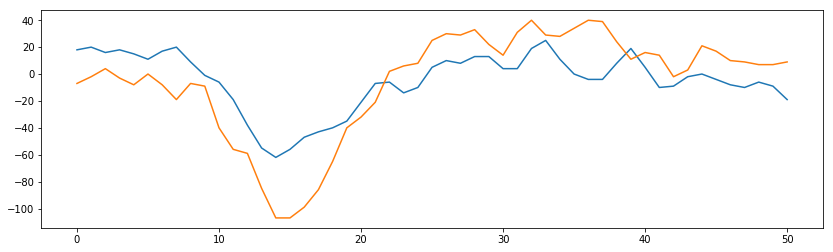

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [11]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [9]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [12]:
train_lim = (int)(0.85*electrode_data.shape[0])
val_lim = (int)(0.9*electrode_data.shape[0])

electrode_data_train = electrode_data[:train_lim, :]
electrode_data_val = electrode_data[train_lim:val_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (27902, 51)
Test Datasize: (4924, 51)


# Helper Functions

In [13]:
def find_scaled_mse(original, recons, params=None):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    if params is not None:
        print(params, np.median(mse))
    mse = np.array(mse)
    return mse, np.median(mse)

In [14]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [15]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs, filename, figsize = (7,5), ylabel=""):
    fig = plt.figure(1, figsize=figsize)
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.xlabel('Autoencoder Models', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

In [16]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        #print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder, corrs

In [17]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [18]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [19]:
random.seed(0)

def train_ae(model, input_data, val_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    v_losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        x = np.zeros((batch_size, 51))
        for i, feats in enumerate(selected):
            x[i, :] = input_data[feats, :]
        x = torch.from_numpy(x).float().cuda()
        #---------FORWARD------------#
        enc, out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, x)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(electrode_data_val)), 20)
        v_data = np.zeros((20, 51))
        for i, feats in enumerate(v):
            v_data[i, :] = electrode_data_val[feats, :]
        v_data = torch.from_numpy(v_data).float().cuda()
        _, v_out = model.forward(v_data)
        v_out = torch.tensor(v_out).float().cuda()
        vloss = criterion(v_out, v_data)
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return enc, out, losses, v_losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple Shallow

In [20]:
# input -> 50 -> 12 -> emb -> 12 -> 50 -> input

class autoencoder_shallow(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_shallow, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 50),
                                     activation_layer,
                                     nn.Linear(50, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 50),
                                     activation_layer,
                                     nn.Linear(50, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [19]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_14 = autoencoder_shallow(length, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_12 = autoencoder_shallow(length, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12, vlosses_12 = train_ae(ae_12, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_1_4', np.array(losses_14))
np.save('models/final_models/losses_1_2', np.array(losses_12))
np.save('models/final_models/vlosses_1_2', np.array(vlosses_12))


# Saving Models
#torch.save(ae_14, 'models/final_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/final_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 6525
epoch [1/350000], loss:1589.61730957, val:1915.95178223
epoch [101/350000], loss:1596.07897949, val:1289.84619141
epoch [201/350000], loss:1318.14001465, val:1178.00793457
epoch [301/350000], loss:669.13842773, val:601.47906494
epoch [401/350000], loss:295.66513062, val:230.79118347
epoch [501/350000], loss:254.11233521, val:192.08229065
epoch [601/350000], loss:238.30087280, val:211.03459167
epoch [701/350000], loss:234.53698730, val:240.11091614
epoch [801/350000], loss:220.55819702, val:188.40499878
epoch [901/350000], loss:218.91049194, val:200.04602051
epoch [1001/350000], loss:202.99003601, val:358.52172852
epoch [1101/350000], loss:177.98684692, val:205.85873413
epoch [1201/350000], loss:169.77702332, val:147.27317810
epoch [1301/350000], loss:169.21696472, val:143.53991699
epoch [1401/350000], loss:154.12268066, val:199.53286743
epoch [1501/350000], loss:146.30944824, val:137.50833130
epoch [1601/350000], loss:145.79904175, val:141.90533447
epoc

epoch [14301/350000], loss:126.13751984, val:119.24300385
epoch [14401/350000], loss:122.09900665, val:130.92541504
epoch [14501/350000], loss:134.49978638, val:109.48796082
epoch [14601/350000], loss:121.14928436, val:126.21008301
epoch [14701/350000], loss:133.91000366, val:111.78533936
epoch [14801/350000], loss:130.55877686, val:161.25584412
epoch [14901/350000], loss:123.52664948, val:101.59911346
epoch [15001/350000], loss:129.32905579, val:116.80789185
epoch [15101/350000], loss:114.05781555, val:118.57698059
epoch [15201/350000], loss:129.26498413, val:82.83967590
epoch [15301/350000], loss:131.42286682, val:90.68595123
epoch [15401/350000], loss:129.70091248, val:113.49851227
epoch [15501/350000], loss:133.22721863, val:81.49660492
epoch [15601/350000], loss:119.97931671, val:140.94781494
epoch [15701/350000], loss:126.92627716, val:132.81185913
epoch [15801/350000], loss:124.76679993, val:116.34181976
epoch [15901/350000], loss:122.98966217, val:142.43614197
epoch [16001/3500

epoch [28501/350000], loss:125.67398834, val:109.04066467
epoch [28601/350000], loss:129.15185547, val:162.86814880
epoch [28701/350000], loss:137.91142273, val:96.51489258
epoch [28801/350000], loss:139.58512878, val:124.60324860
epoch [28901/350000], loss:126.89243317, val:133.91636658
epoch [29001/350000], loss:141.37806702, val:128.96937561
epoch [29101/350000], loss:119.37664795, val:125.07173920
epoch [29201/350000], loss:135.10221863, val:114.14874268
epoch [29301/350000], loss:123.58925629, val:149.16812134
epoch [29401/350000], loss:127.48426819, val:94.08697510
epoch [29501/350000], loss:130.24237061, val:105.65454865
epoch [29601/350000], loss:121.99605560, val:115.87419128
epoch [29701/350000], loss:119.78748322, val:117.78811646
epoch [29801/350000], loss:130.57560730, val:124.86744690
epoch [29901/350000], loss:127.51915741, val:118.71369171
epoch [30001/350000], loss:126.69881439, val:133.16798401
epoch [30101/350000], loss:120.29187012, val:127.75445557
epoch [30201/350

epoch [42701/350000], loss:130.50561523, val:113.79741669
epoch [42801/350000], loss:120.83634949, val:127.74362946
epoch [42901/350000], loss:118.27345276, val:117.31818390
epoch [43001/350000], loss:123.90449524, val:153.36911011
epoch [43101/350000], loss:131.58854675, val:181.95077515
epoch [43201/350000], loss:122.39753723, val:111.92562866
epoch [43301/350000], loss:133.26997375, val:125.39757538
epoch [43401/350000], loss:128.15266418, val:110.69261932
epoch [43501/350000], loss:132.54505920, val:126.18254852
epoch [43601/350000], loss:124.18821716, val:102.29749298
epoch [43701/350000], loss:124.52944946, val:111.46844482
epoch [43801/350000], loss:121.80352783, val:118.49161530
epoch [43901/350000], loss:125.88848114, val:110.36795044
epoch [44001/350000], loss:127.33684540, val:193.62982178
epoch [44101/350000], loss:134.10017395, val:124.13970947
epoch [44201/350000], loss:124.34695435, val:113.46250916
epoch [44301/350000], loss:120.65896606, val:107.81742859
epoch [44401/3

epoch [56901/350000], loss:118.21981812, val:92.60942078
epoch [57001/350000], loss:119.14787292, val:105.63877869
epoch [57101/350000], loss:120.57482147, val:135.57963562
epoch [57201/350000], loss:127.66104889, val:103.22807312
epoch [57301/350000], loss:128.39192200, val:114.63874817
epoch [57401/350000], loss:121.45683289, val:104.26065063
epoch [57501/350000], loss:138.40554810, val:114.40962219
epoch [57601/350000], loss:116.73025513, val:132.26118469
epoch [57701/350000], loss:128.50065613, val:95.73195648
epoch [57801/350000], loss:125.47078705, val:103.05835724
epoch [57901/350000], loss:120.96238708, val:79.29878998
epoch [58001/350000], loss:138.00178528, val:115.09101105
epoch [58101/350000], loss:126.51746368, val:127.91112518
epoch [58201/350000], loss:134.34236145, val:100.98528290
epoch [58301/350000], loss:123.27515411, val:139.79763794
epoch [58401/350000], loss:127.61505127, val:101.44087982
epoch [58501/350000], loss:120.71269989, val:95.25695038
epoch [58601/35000

epoch [71101/350000], loss:122.78965759, val:107.42656708
epoch [71201/350000], loss:121.24536896, val:110.98226929
epoch [71301/350000], loss:136.63836670, val:109.38056183
epoch [71401/350000], loss:125.97254944, val:116.86244202
epoch [71501/350000], loss:125.11415863, val:102.03967285
epoch [71601/350000], loss:114.77995300, val:126.15065765
epoch [71701/350000], loss:122.26414490, val:121.15836334
epoch [71801/350000], loss:124.23900604, val:103.41548920
epoch [71901/350000], loss:116.57828522, val:132.73599243
epoch [72001/350000], loss:117.82353210, val:159.17591858
epoch [72101/350000], loss:120.16027832, val:108.70803070
epoch [72201/350000], loss:125.29257965, val:103.86105347
epoch [72301/350000], loss:124.09146881, val:126.78431702
epoch [72401/350000], loss:130.13963318, val:124.95723724
epoch [72501/350000], loss:118.43555450, val:104.68230438
epoch [72601/350000], loss:123.05265808, val:148.86683655
epoch [72701/350000], loss:117.81086731, val:105.01492310
epoch [72801/3

epoch [85301/350000], loss:130.46397400, val:85.95302582
epoch [85401/350000], loss:128.20901489, val:113.54400635
epoch [85501/350000], loss:128.18951416, val:118.64943695
epoch [85601/350000], loss:122.86210632, val:127.16949463
epoch [85701/350000], loss:117.93475342, val:202.92276001
epoch [85801/350000], loss:116.36782837, val:107.34977722
epoch [85901/350000], loss:128.32983398, val:116.81455231
epoch [86001/350000], loss:130.83534241, val:111.13385010
epoch [86101/350000], loss:124.47109222, val:112.42172241
epoch [86201/350000], loss:130.08883667, val:93.99186707
epoch [86301/350000], loss:124.31393433, val:101.59071350
epoch [86401/350000], loss:122.87465668, val:115.75595093
epoch [86501/350000], loss:123.45008087, val:102.46585083
epoch [86601/350000], loss:128.07511902, val:176.59991455
epoch [86701/350000], loss:130.22526550, val:187.13977051
epoch [86801/350000], loss:137.26373291, val:99.23512268
epoch [86901/350000], loss:134.34449768, val:105.04536438
epoch [87001/3500

epoch [99501/350000], loss:123.09171295, val:123.03825378
epoch [99601/350000], loss:128.39607239, val:118.34118652
epoch [99701/350000], loss:115.22785187, val:118.06920624
epoch [99801/350000], loss:128.00869751, val:112.58446503
epoch [99901/350000], loss:117.23435974, val:127.54649353
epoch [100001/350000], loss:121.86859131, val:115.23780823
epoch [100101/350000], loss:122.76863098, val:115.01018524
epoch [100201/350000], loss:130.85787964, val:124.91301727
epoch [100301/350000], loss:122.17620850, val:102.62625122
epoch [100401/350000], loss:130.95201111, val:123.76458740
epoch [100501/350000], loss:122.66089630, val:146.83662415
epoch [100601/350000], loss:116.14328766, val:128.76048279
epoch [100701/350000], loss:141.07931519, val:104.45024872
epoch [100801/350000], loss:133.04502869, val:81.23117065
epoch [100901/350000], loss:123.51385498, val:112.13265991
epoch [101001/350000], loss:136.52069092, val:116.77207947
epoch [101101/350000], loss:130.13754272, val:120.83395386
epo

epoch [113501/350000], loss:121.08695984, val:180.04969788
epoch [113601/350000], loss:124.05728912, val:94.20893097
epoch [113701/350000], loss:119.88457489, val:140.39317322
epoch [113801/350000], loss:136.39530945, val:116.91159821
epoch [113901/350000], loss:124.89265442, val:107.48165131
epoch [114001/350000], loss:116.82390594, val:102.57452393
epoch [114101/350000], loss:128.90841675, val:119.61894989
epoch [114201/350000], loss:119.58687592, val:109.27399445
epoch [114301/350000], loss:128.28474426, val:112.14277649
epoch [114401/350000], loss:118.80006409, val:126.22476959
epoch [114501/350000], loss:117.94702911, val:91.67462921
epoch [114601/350000], loss:123.40393829, val:154.22616577
epoch [114701/350000], loss:125.69071960, val:177.44433594
epoch [114801/350000], loss:135.93879700, val:120.16110992
epoch [114901/350000], loss:121.32983398, val:90.44609833
epoch [115001/350000], loss:134.55337524, val:115.18564606
epoch [115101/350000], loss:120.76911163, val:131.42234802


epoch [127501/350000], loss:124.59608459, val:97.94582367
epoch [127601/350000], loss:126.38121033, val:144.19902039
epoch [127701/350000], loss:129.00250244, val:141.83473206
epoch [127801/350000], loss:127.23609161, val:112.44741058
epoch [127901/350000], loss:129.03330994, val:130.75178528
epoch [128001/350000], loss:133.43780518, val:113.43629456
epoch [128101/350000], loss:127.71354675, val:105.95565796
epoch [128201/350000], loss:125.78466034, val:119.13761902
epoch [128301/350000], loss:122.59571838, val:177.82066345
epoch [128401/350000], loss:118.35060120, val:102.58072662
epoch [128501/350000], loss:128.53849792, val:155.01345825
epoch [128601/350000], loss:123.93562317, val:101.14985657
epoch [128701/350000], loss:129.32736206, val:96.41173553
epoch [128801/350000], loss:126.78328705, val:105.63632202
epoch [128901/350000], loss:121.94042206, val:101.20394897
epoch [129001/350000], loss:123.79529572, val:112.69055176
epoch [129101/350000], loss:119.12326050, val:117.29345703

epoch [141501/350000], loss:127.36147308, val:145.64080811
epoch [141601/350000], loss:122.30022430, val:97.13645935
epoch [141701/350000], loss:125.70000458, val:150.93482971
epoch [141801/350000], loss:124.22232819, val:122.99547577
epoch [141901/350000], loss:125.83626556, val:140.13038635
epoch [142001/350000], loss:129.21879578, val:111.48504639
epoch [142101/350000], loss:127.67021179, val:117.81065369
epoch [142201/350000], loss:121.74805450, val:89.78927612
epoch [142301/350000], loss:118.89708710, val:112.78749084
epoch [142401/350000], loss:126.77260590, val:106.47847748
epoch [142501/350000], loss:118.14604950, val:113.96209717
epoch [142601/350000], loss:122.18657684, val:114.13709259
epoch [142701/350000], loss:127.52880859, val:85.51265717
epoch [142801/350000], loss:127.93740845, val:112.00866699
epoch [142901/350000], loss:127.24635315, val:132.60009766
epoch [143001/350000], loss:129.62928772, val:144.94328308
epoch [143101/350000], loss:120.97568512, val:99.33866119
e

epoch [155501/350000], loss:120.29411316, val:103.68154907
epoch [155601/350000], loss:121.42990112, val:121.19058228
epoch [155701/350000], loss:129.86201477, val:98.40910339
epoch [155801/350000], loss:122.45191956, val:91.94589233
epoch [155901/350000], loss:124.80672455, val:139.74249268
epoch [156001/350000], loss:137.02455139, val:122.24378204
epoch [156101/350000], loss:130.92503357, val:171.66238403
epoch [156201/350000], loss:124.66119385, val:122.62078857
epoch [156301/350000], loss:130.41462708, val:126.48900604
epoch [156401/350000], loss:145.19616699, val:109.68676758
epoch [156501/350000], loss:119.61162567, val:114.73475647
epoch [156601/350000], loss:126.75907898, val:141.13970947
epoch [156701/350000], loss:118.25931549, val:125.32003784
epoch [156801/350000], loss:130.07867432, val:100.40792084
epoch [156901/350000], loss:135.60925293, val:106.77961731
epoch [157001/350000], loss:124.07046509, val:110.36363220
epoch [157101/350000], loss:128.70535278, val:98.06919861


epoch [169501/350000], loss:120.10420990, val:100.83913422
epoch [169601/350000], loss:138.51011658, val:93.90453339
epoch [169701/350000], loss:129.71279907, val:101.78070068
epoch [169801/350000], loss:122.25622559, val:132.61968994
epoch [169901/350000], loss:132.24398804, val:101.26528931
epoch [170001/350000], loss:127.74078369, val:114.87210083
epoch [170101/350000], loss:130.19030762, val:149.06298828
epoch [170201/350000], loss:124.91565704, val:137.24525452
epoch [170301/350000], loss:122.64236450, val:154.36860657
epoch [170401/350000], loss:119.24619293, val:135.05703735
epoch [170501/350000], loss:133.80339050, val:102.86072540
epoch [170601/350000], loss:119.45176697, val:149.81950378
epoch [170701/350000], loss:120.81529236, val:138.17027283
epoch [170801/350000], loss:119.16328430, val:119.68242645
epoch [170901/350000], loss:127.69380188, val:99.14050293
epoch [171001/350000], loss:131.61503601, val:110.82793427
epoch [171101/350000], loss:117.28602600, val:114.45541382

epoch [183501/350000], loss:124.27541351, val:129.49624634
epoch [183601/350000], loss:136.15100098, val:103.86100006
epoch [183701/350000], loss:133.99494934, val:140.60461426
epoch [183801/350000], loss:130.41848755, val:115.16874695
epoch [183901/350000], loss:118.48923492, val:93.48835754
epoch [184001/350000], loss:117.77483368, val:100.66659546
epoch [184101/350000], loss:130.27676392, val:109.17385864
epoch [184201/350000], loss:118.21137238, val:148.44934082
epoch [184301/350000], loss:125.73919678, val:159.05165100
epoch [184401/350000], loss:121.05145264, val:149.10832214
epoch [184501/350000], loss:124.56618500, val:125.27676392
epoch [184601/350000], loss:123.88935089, val:109.44213867
epoch [184701/350000], loss:123.13536072, val:100.91937256
epoch [184801/350000], loss:122.06174469, val:108.84052277
epoch [184901/350000], loss:132.47027588, val:96.13613892
epoch [185001/350000], loss:119.27815247, val:138.37303162
epoch [185101/350000], loss:122.35135651, val:99.51752472


epoch [197501/350000], loss:124.01092529, val:119.16510010
epoch [197601/350000], loss:120.56925201, val:132.02435303
epoch [197701/350000], loss:126.56069946, val:104.22494507
epoch [197801/350000], loss:131.85861206, val:112.95222473
epoch [197901/350000], loss:126.01993561, val:154.80653381
epoch [198001/350000], loss:126.95749664, val:115.34249115
epoch [198101/350000], loss:132.38395691, val:107.59026337
epoch [198201/350000], loss:120.01652527, val:117.50817108
epoch [198301/350000], loss:123.51184845, val:102.14120483
epoch [198401/350000], loss:121.99065399, val:101.48028564
epoch [198501/350000], loss:122.78807068, val:129.04173279
epoch [198601/350000], loss:123.66583252, val:110.56501007
epoch [198701/350000], loss:127.48431396, val:125.96502686
epoch [198801/350000], loss:127.38127899, val:101.62638092
epoch [198901/350000], loss:119.58077240, val:114.49454498
epoch [199001/350000], loss:125.75891113, val:149.04837036
epoch [199101/350000], loss:120.16792297, val:87.7628402

epoch [211501/350000], loss:130.82376099, val:94.42169189
epoch [211601/350000], loss:127.22975159, val:123.38674927
epoch [211701/350000], loss:125.72748566, val:112.56813812
epoch [211801/350000], loss:115.04322052, val:99.65272522
epoch [211901/350000], loss:116.47199249, val:128.84114075
epoch [212001/350000], loss:124.02490234, val:121.41938782
epoch [212101/350000], loss:125.55791473, val:88.82304382
epoch [212201/350000], loss:119.39970398, val:117.34316254
epoch [212301/350000], loss:120.18140411, val:122.26084900
epoch [212401/350000], loss:125.10566711, val:107.75809479
epoch [212501/350000], loss:120.97972107, val:101.59558105
epoch [212601/350000], loss:123.39759827, val:143.49943542
epoch [212701/350000], loss:134.54895020, val:113.01477051
epoch [212801/350000], loss:127.42127228, val:93.11035919
epoch [212901/350000], loss:116.71797943, val:113.55676270
epoch [213001/350000], loss:123.59951782, val:106.81164551
epoch [213101/350000], loss:120.95723724, val:117.78462219
e

epoch [225501/350000], loss:126.20687103, val:105.46022034
epoch [225601/350000], loss:124.94040680, val:100.48750305
epoch [225701/350000], loss:130.42297363, val:161.18215942
epoch [225801/350000], loss:129.81729126, val:98.75183868
epoch [225901/350000], loss:120.50637054, val:99.93390656
epoch [226001/350000], loss:126.80017090, val:101.14727783
epoch [226101/350000], loss:124.40423584, val:104.93597412
epoch [226201/350000], loss:120.30839539, val:116.31291962
epoch [226301/350000], loss:132.83079529, val:126.94523621
epoch [226401/350000], loss:125.71256256, val:95.60587311
epoch [226501/350000], loss:129.16664124, val:107.15297699
epoch [226601/350000], loss:133.30796814, val:118.86067963
epoch [226701/350000], loss:127.10035706, val:106.23582458
epoch [226801/350000], loss:128.82257080, val:109.69078064
epoch [226901/350000], loss:126.46758270, val:162.13381958
epoch [227001/350000], loss:121.23486328, val:111.43995667
epoch [227101/350000], loss:123.93278503, val:107.37164307


epoch [239501/350000], loss:125.87441254, val:109.84333801
epoch [239601/350000], loss:121.34129333, val:166.03678894
epoch [239701/350000], loss:129.94822693, val:91.41528320
epoch [239801/350000], loss:127.06205750, val:108.14767456
epoch [239901/350000], loss:119.88672638, val:106.46680450
epoch [240001/350000], loss:130.19665527, val:123.73828888
epoch [240101/350000], loss:131.57702637, val:104.11135864
epoch [240201/350000], loss:122.73228455, val:120.43025208
epoch [240301/350000], loss:134.36692810, val:110.34503937
epoch [240401/350000], loss:122.87395477, val:112.93362427
epoch [240501/350000], loss:128.49809265, val:112.37533569
epoch [240601/350000], loss:123.40435791, val:99.02316284
epoch [240701/350000], loss:122.34187317, val:105.92763519
epoch [240801/350000], loss:122.93309021, val:110.40068817
epoch [240901/350000], loss:123.71102905, val:105.11288452
epoch [241001/350000], loss:125.03115845, val:138.67359924
epoch [241101/350000], loss:117.64842987, val:161.70535278

epoch [253501/350000], loss:126.65908813, val:149.08422852
epoch [253601/350000], loss:113.40525818, val:95.76278687
epoch [253701/350000], loss:131.48995972, val:133.60884094
epoch [253801/350000], loss:119.62236023, val:159.41970825
epoch [253901/350000], loss:122.53320312, val:105.29443359
epoch [254001/350000], loss:126.51368713, val:106.47168732
epoch [254101/350000], loss:120.95802307, val:151.12689209
epoch [254201/350000], loss:125.28552246, val:110.27237701
epoch [254301/350000], loss:128.46566772, val:159.37242126
epoch [254401/350000], loss:116.31610870, val:135.46096802
epoch [254501/350000], loss:120.59660339, val:103.90687561
epoch [254601/350000], loss:127.32573700, val:140.33258057
epoch [254701/350000], loss:119.61907196, val:115.07845306
epoch [254801/350000], loss:122.63687897, val:123.51478577
epoch [254901/350000], loss:119.58513641, val:128.82186890
epoch [255001/350000], loss:125.65405273, val:105.39316559
epoch [255101/350000], loss:123.96993256, val:117.3083496

epoch [267501/350000], loss:132.74792480, val:119.50812531
epoch [267601/350000], loss:132.18511963, val:101.18046570
epoch [267701/350000], loss:128.84527588, val:103.85437775
epoch [267801/350000], loss:130.67254639, val:84.10259247
epoch [267901/350000], loss:132.94941711, val:140.93289185
epoch [268001/350000], loss:118.29548645, val:132.89540100
epoch [268101/350000], loss:121.68372345, val:182.50119019
epoch [268201/350000], loss:123.01662445, val:138.75151062
epoch [268301/350000], loss:135.50213623, val:123.24617004
epoch [268401/350000], loss:121.61866760, val:112.90202332
epoch [268501/350000], loss:131.16947937, val:117.55872345
epoch [268601/350000], loss:123.68058014, val:101.36471558
epoch [268701/350000], loss:130.04882812, val:137.23457336
epoch [268801/350000], loss:126.66184998, val:122.08671570
epoch [268901/350000], loss:124.10257721, val:158.19761658
epoch [269001/350000], loss:123.55635071, val:139.03137207
epoch [269101/350000], loss:122.59187317, val:106.1733169

epoch [281501/350000], loss:118.13710785, val:117.80817413
epoch [281601/350000], loss:120.22748566, val:84.92804718
epoch [281701/350000], loss:130.41551208, val:103.18536377
epoch [281801/350000], loss:138.83731079, val:89.41574097
epoch [281901/350000], loss:117.15897369, val:149.99284363
epoch [282001/350000], loss:119.99559021, val:99.62819672
epoch [282101/350000], loss:128.42190552, val:125.91252899
epoch [282201/350000], loss:119.38777924, val:116.67266846
epoch [282301/350000], loss:120.52790070, val:157.21121216
epoch [282401/350000], loss:119.30675507, val:116.33354950
epoch [282501/350000], loss:123.39331818, val:112.74570465
epoch [282601/350000], loss:134.82878113, val:89.14035034
epoch [282701/350000], loss:130.74198914, val:142.79539490
epoch [282801/350000], loss:125.40651703, val:117.76099396
epoch [282901/350000], loss:130.13285828, val:108.12285614
epoch [283001/350000], loss:122.95027924, val:107.70711517
epoch [283101/350000], loss:123.50260162, val:190.76429749
e

epoch [295501/350000], loss:120.68210602, val:95.32436371
epoch [295601/350000], loss:119.64289093, val:103.84786987
epoch [295701/350000], loss:115.59880066, val:110.76298523
epoch [295801/350000], loss:124.30879211, val:107.24333954
epoch [295901/350000], loss:120.37695312, val:89.75028229
epoch [296001/350000], loss:126.36486816, val:99.34282684
epoch [296101/350000], loss:118.38649750, val:98.80249023
epoch [296201/350000], loss:132.88310242, val:93.74556732
epoch [296301/350000], loss:121.50492859, val:115.06577301
epoch [296401/350000], loss:128.81263733, val:159.74096680
epoch [296501/350000], loss:126.28662872, val:100.68972015
epoch [296601/350000], loss:125.44385529, val:99.63541412
epoch [296701/350000], loss:124.15322113, val:119.32559204
epoch [296801/350000], loss:126.11788940, val:112.78513336
epoch [296901/350000], loss:128.03298950, val:138.55000305
epoch [297001/350000], loss:126.42207336, val:92.76406097
epoch [297101/350000], loss:123.10353088, val:110.66984558
epoc

epoch [309501/350000], loss:127.00897217, val:97.40925598
epoch [309601/350000], loss:141.54263306, val:70.16121674
epoch [309701/350000], loss:126.59143066, val:164.67004395
epoch [309801/350000], loss:127.96398926, val:171.60021973
epoch [309901/350000], loss:131.12356567, val:98.61750793
epoch [310001/350000], loss:122.53909302, val:121.88471985
epoch [310101/350000], loss:123.17221069, val:90.89471436
epoch [310201/350000], loss:127.29545593, val:111.26486206
epoch [310301/350000], loss:127.29506683, val:186.76068115
epoch [310401/350000], loss:130.57585144, val:147.07209778
epoch [310501/350000], loss:126.77424622, val:128.74272156
epoch [310601/350000], loss:127.39344788, val:104.37731934
epoch [310701/350000], loss:134.06591797, val:86.42130280
epoch [310801/350000], loss:120.80438232, val:112.08505249
epoch [310901/350000], loss:120.29622650, val:150.20960999
epoch [311001/350000], loss:121.17294312, val:114.00843811
epoch [311101/350000], loss:118.03254700, val:118.13915253
ep

epoch [323501/350000], loss:121.93923187, val:107.53118896
epoch [323601/350000], loss:125.31056976, val:189.28103638
epoch [323701/350000], loss:125.62916565, val:124.98104858
epoch [323801/350000], loss:128.07951355, val:124.79865265
epoch [323901/350000], loss:134.79058838, val:91.73764038
epoch [324001/350000], loss:127.88772583, val:119.78616333
epoch [324101/350000], loss:123.89248657, val:128.57041931
epoch [324201/350000], loss:124.26657867, val:116.62600708
epoch [324301/350000], loss:129.52914429, val:118.93446350
epoch [324401/350000], loss:132.80014038, val:109.80677032
epoch [324501/350000], loss:124.76727295, val:85.05754852
epoch [324601/350000], loss:131.99319458, val:114.72600555
epoch [324701/350000], loss:133.35009766, val:188.87037659
epoch [324801/350000], loss:125.65419769, val:109.76705933
epoch [324901/350000], loss:131.31806946, val:91.26546478
epoch [325001/350000], loss:119.99720764, val:103.33134460
epoch [325101/350000], loss:120.86473083, val:107.55470276


epoch [337501/350000], loss:125.66289520, val:125.87415314
epoch [337601/350000], loss:119.79640198, val:100.33740997
epoch [337701/350000], loss:124.74840546, val:112.21150208
epoch [337801/350000], loss:139.00709534, val:82.01699066
epoch [337901/350000], loss:118.35238647, val:127.94070435
epoch [338001/350000], loss:126.40462494, val:111.94881439
epoch [338101/350000], loss:128.00698853, val:104.51444244
epoch [338201/350000], loss:126.43274689, val:101.72524261
epoch [338301/350000], loss:123.60023499, val:120.94423676
epoch [338401/350000], loss:119.23400116, val:83.84039307
epoch [338501/350000], loss:118.78929901, val:81.75978851
epoch [338601/350000], loss:128.05755615, val:115.46607971
epoch [338701/350000], loss:123.03012848, val:96.19227600
epoch [338801/350000], loss:132.62777710, val:90.96268463
epoch [338901/350000], loss:126.09782410, val:105.24361420
epoch [339001/350000], loss:132.08488464, val:106.98332977
epoch [339101/350000], loss:121.72914886, val:138.85977173
ep

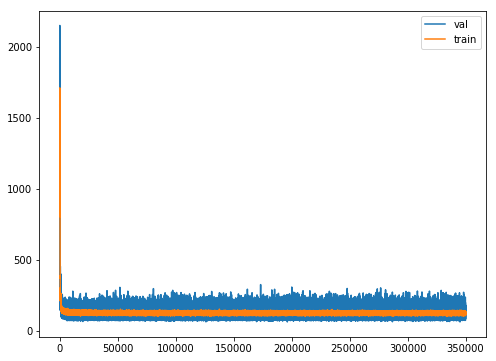

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(vlosses_12, label="val")
plt.plot(losses_12, label="train")
plt.legend()
plt.show()

In [21]:
ae_1 = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9473261786377375
PCA 0.9473133023945347


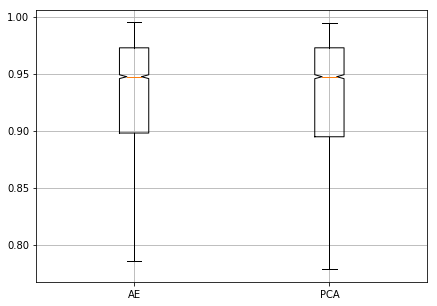

In [22]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754661194
AE 3.2096299964494976


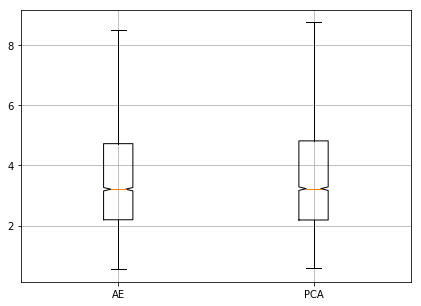

In [23]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple Deep

In [21]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_deep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_deep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 50),
                                     activation_layer,
                                     nn.Linear(50, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [25]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_44 = autoencoder_deep(length, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_42 = autoencoder_deep(length, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42, vlosses_42 = train_ae(ae_42, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_4_4', np.array(losses_44))
np.save('models/final_models/vlosses_4_2', np.array(vlosses_42))
np.save('models/final_models/losses_4_2', np.array(losses_42))


# Saving Models
#torch.save(ae_44, 'models/final_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/final_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 23775
epoch [1/350000], loss:1681.40380859, val:1069.39453125
epoch [101/350000], loss:917.17840576, val:778.50018311
epoch [201/350000], loss:245.42327881, val:270.99401855
epoch [301/350000], loss:242.81652832, val:209.31617737
epoch [401/350000], loss:224.81520081, val:193.05703735
epoch [501/350000], loss:225.25335693, val:200.13069153
epoch [601/350000], loss:194.26078796, val:167.01081848
epoch [701/350000], loss:159.11911011, val:277.84564209
epoch [801/350000], loss:160.70790100, val:118.45366669
epoch [901/350000], loss:149.71614075, val:124.35936737
epoch [1001/350000], loss:144.47515869, val:145.42610168
epoch [1101/350000], loss:138.79006958, val:129.53552246
epoch [1201/350000], loss:138.88914490, val:102.65908813
epoch [1301/350000], loss:132.09155273, val:124.70684814
epoch [1401/350000], loss:138.26376343, val:122.54067230
epoch [1501/350000], loss:141.87117004, val:135.00370789
epoch [1601/350000], loss:159.51240540, val:121.05235291
epoch [

epoch [14301/350000], loss:136.24626160, val:94.62876892
epoch [14401/350000], loss:116.77194214, val:106.70724487
epoch [14501/350000], loss:132.38034058, val:101.24327087
epoch [14601/350000], loss:125.17362976, val:125.76969147
epoch [14701/350000], loss:132.52478027, val:129.14523315
epoch [14801/350000], loss:130.39724731, val:87.74488068
epoch [14901/350000], loss:126.26542664, val:84.99938202
epoch [15001/350000], loss:123.97232056, val:149.88613892
epoch [15101/350000], loss:115.93424225, val:120.57915497
epoch [15201/350000], loss:126.71303558, val:116.10048676
epoch [15301/350000], loss:128.32546997, val:116.70507812
epoch [15401/350000], loss:118.84985352, val:147.31365967
epoch [15501/350000], loss:124.75988770, val:86.55716705
epoch [15601/350000], loss:129.55603027, val:137.20771790
epoch [15701/350000], loss:133.72679138, val:133.58824158
epoch [15801/350000], loss:124.43444824, val:113.30992126
epoch [15901/350000], loss:119.62490082, val:123.11352539
epoch [16001/35000

epoch [28501/350000], loss:119.44820404, val:96.23115540
epoch [28601/350000], loss:124.86882019, val:152.03358459
epoch [28701/350000], loss:130.23838806, val:114.83721924
epoch [28801/350000], loss:129.32911682, val:120.68639374
epoch [28901/350000], loss:123.72685242, val:121.85182953
epoch [29001/350000], loss:136.99859619, val:110.61022949
epoch [29101/350000], loss:124.84815979, val:92.50980377
epoch [29201/350000], loss:145.39970398, val:122.00689697
epoch [29301/350000], loss:111.71320343, val:193.67301941
epoch [29401/350000], loss:108.64518738, val:114.59127808
epoch [29501/350000], loss:121.82465363, val:136.51455688
epoch [29601/350000], loss:113.59957886, val:116.71782684
epoch [29701/350000], loss:119.62828064, val:83.81996155
epoch [29801/350000], loss:119.95691681, val:114.75299835
epoch [29901/350000], loss:119.24045563, val:146.84584045
epoch [30001/350000], loss:116.76743317, val:96.68333435
epoch [30101/350000], loss:126.54255676, val:161.44898987
epoch [30201/35000

epoch [42701/350000], loss:116.56161499, val:120.22271729
epoch [42801/350000], loss:117.27725983, val:126.67726135
epoch [42901/350000], loss:117.75102997, val:102.68496704
epoch [43001/350000], loss:118.05994415, val:91.59181976
epoch [43101/350000], loss:125.55744934, val:91.50044250
epoch [43201/350000], loss:119.21939850, val:107.51348114
epoch [43301/350000], loss:120.20169830, val:143.25331116
epoch [43401/350000], loss:116.57552338, val:272.22463989
epoch [43501/350000], loss:112.28206635, val:122.82587433
epoch [43601/350000], loss:118.54679871, val:94.82418823
epoch [43701/350000], loss:118.71014404, val:104.13208008
epoch [43801/350000], loss:119.48266602, val:144.66120911
epoch [43901/350000], loss:116.38955688, val:98.17530823
epoch [44001/350000], loss:117.93665314, val:125.69071960
epoch [44101/350000], loss:113.38150024, val:110.71333313
epoch [44201/350000], loss:120.43068695, val:135.91676331
epoch [44301/350000], loss:125.32679749, val:105.70871735
epoch [44401/35000

epoch [56901/350000], loss:118.16467285, val:113.07454681
epoch [57001/350000], loss:116.39781189, val:91.82051086
epoch [57101/350000], loss:114.50965881, val:106.02645111
epoch [57201/350000], loss:116.89653778, val:97.92691040
epoch [57301/350000], loss:122.67857361, val:120.38484955
epoch [57401/350000], loss:115.12578583, val:125.25833893
epoch [57501/350000], loss:110.32970428, val:126.08256531
epoch [57601/350000], loss:119.63673401, val:122.05149841
epoch [57701/350000], loss:111.65935516, val:152.50929260
epoch [57801/350000], loss:119.46405029, val:154.98208618
epoch [57901/350000], loss:116.60955048, val:96.30893707
epoch [58001/350000], loss:117.11527252, val:117.68186188
epoch [58101/350000], loss:121.64608002, val:109.52172089
epoch [58201/350000], loss:117.99193573, val:167.87490845
epoch [58301/350000], loss:110.75045776, val:109.35781860
epoch [58401/350000], loss:111.22068787, val:151.79267883
epoch [58501/350000], loss:113.29546356, val:84.06971741
epoch [58601/35000

epoch [71101/350000], loss:117.59642792, val:150.44599915
epoch [71201/350000], loss:112.28876495, val:103.29398346
epoch [71301/350000], loss:109.88364410, val:112.75194550
epoch [71401/350000], loss:114.17177582, val:118.36254120
epoch [71501/350000], loss:113.10018158, val:100.11326599
epoch [71601/350000], loss:110.49307251, val:138.43707275
epoch [71701/350000], loss:110.17404938, val:103.67892456
epoch [71801/350000], loss:116.91856384, val:111.01484680
epoch [71901/350000], loss:113.00003815, val:94.84825897
epoch [72001/350000], loss:110.14568329, val:110.92768860
epoch [72101/350000], loss:109.42142487, val:116.58451843
epoch [72201/350000], loss:111.74029541, val:96.25500488
epoch [72301/350000], loss:120.45198822, val:119.41027832
epoch [72401/350000], loss:113.44738770, val:86.62670135
epoch [72501/350000], loss:122.16255188, val:113.29758453
epoch [72601/350000], loss:108.10922241, val:106.14015198
epoch [72701/350000], loss:111.86566925, val:102.25156403
epoch [72801/3500

epoch [85401/350000], loss:107.45908356, val:98.31916809
epoch [85501/350000], loss:105.95942688, val:82.75895691
epoch [85601/350000], loss:106.48402405, val:128.12263489
epoch [85701/350000], loss:104.75312042, val:98.94227600
epoch [85801/350000], loss:103.02962494, val:92.74867249
epoch [85901/350000], loss:108.07640839, val:88.85661316
epoch [86001/350000], loss:100.76359558, val:91.14831543
epoch [86101/350000], loss:105.41690826, val:93.29782867
epoch [86201/350000], loss:105.10402679, val:102.89421082
epoch [86301/350000], loss:112.90442657, val:100.36701202
epoch [86401/350000], loss:105.38998413, val:101.64186096
epoch [86501/350000], loss:112.27579498, val:119.42501831
epoch [86601/350000], loss:106.43631744, val:83.55252075
epoch [86701/350000], loss:105.20803070, val:81.92846680
epoch [86801/350000], loss:99.07485962, val:83.81024170
epoch [86901/350000], loss:110.80239868, val:82.43898010
epoch [87001/350000], loss:111.84089661, val:89.93746185
epoch [87101/350000], loss:

epoch [99701/350000], loss:108.50377655, val:122.90863800
epoch [99801/350000], loss:101.60984802, val:92.37495422
epoch [99901/350000], loss:102.12310791, val:89.43820190
epoch [100001/350000], loss:102.61071777, val:114.45835114
epoch [100101/350000], loss:104.57907104, val:127.13626862
epoch [100201/350000], loss:103.35984802, val:100.74836731
epoch [100301/350000], loss:104.95100403, val:93.29745483
epoch [100401/350000], loss:101.43864441, val:112.12656403
epoch [100501/350000], loss:102.35353088, val:85.66350555
epoch [100601/350000], loss:102.38558197, val:88.01799011
epoch [100701/350000], loss:109.44980621, val:89.37797546
epoch [100801/350000], loss:99.84950256, val:103.51180267
epoch [100901/350000], loss:100.26821136, val:105.99988556
epoch [101001/350000], loss:106.24559021, val:86.79562378
epoch [101101/350000], loss:110.17463684, val:100.11631012
epoch [101201/350000], loss:104.23806000, val:110.40384674
epoch [101301/350000], loss:107.63530731, val:92.62388611
epoch [10

epoch [113801/350000], loss:110.11269379, val:112.80594635
epoch [113901/350000], loss:106.18976593, val:84.12828064
epoch [114001/350000], loss:101.76508331, val:102.10829926
epoch [114101/350000], loss:106.80561066, val:95.77901459
epoch [114201/350000], loss:103.36942291, val:90.69057465
epoch [114301/350000], loss:103.27637482, val:93.80852509
epoch [114401/350000], loss:98.77849579, val:149.33810425
epoch [114501/350000], loss:107.39628601, val:103.37836456
epoch [114601/350000], loss:101.84706116, val:72.32694244
epoch [114701/350000], loss:107.76522064, val:129.13159180
epoch [114801/350000], loss:105.92304993, val:95.63090515
epoch [114901/350000], loss:108.26683044, val:109.77812195
epoch [115001/350000], loss:104.99293518, val:85.68249512
epoch [115101/350000], loss:108.58715820, val:117.34784698
epoch [115201/350000], loss:99.23423004, val:92.34108734
epoch [115301/350000], loss:100.89775848, val:100.85671234
epoch [115401/350000], loss:103.79998016, val:81.93705750
epoch [1

epoch [127901/350000], loss:99.21572113, val:87.10404205
epoch [128001/350000], loss:102.68210602, val:143.70707703
epoch [128101/350000], loss:105.72013092, val:103.63385773
epoch [128201/350000], loss:99.36997986, val:106.26344299
epoch [128301/350000], loss:103.61688232, val:82.08850098
epoch [128401/350000], loss:99.80905151, val:147.61749268
epoch [128501/350000], loss:102.37468719, val:107.46806335
epoch [128601/350000], loss:102.79113007, val:91.34902191
epoch [128701/350000], loss:107.26392365, val:132.46226501
epoch [128801/350000], loss:95.62258148, val:72.31841278
epoch [128901/350000], loss:103.80738068, val:61.60429001
epoch [129001/350000], loss:102.03666687, val:91.74231720
epoch [129101/350000], loss:104.89654541, val:98.44470215
epoch [129201/350000], loss:98.44976807, val:102.23742676
epoch [129301/350000], loss:108.13258362, val:121.47286224
epoch [129401/350000], loss:98.69019318, val:96.73914337
epoch [129501/350000], loss:102.57675171, val:106.81108093
epoch [1296

epoch [142001/350000], loss:105.15170288, val:92.87287140
epoch [142101/350000], loss:103.77324677, val:68.41153717
epoch [142201/350000], loss:103.06470490, val:99.80090332
epoch [142301/350000], loss:103.71411133, val:138.38067627
epoch [142401/350000], loss:108.24137878, val:86.86345673
epoch [142501/350000], loss:106.34245300, val:110.38697052
epoch [142601/350000], loss:100.62173462, val:135.41558838
epoch [142701/350000], loss:99.20057678, val:136.66749573
epoch [142801/350000], loss:104.32283783, val:108.69685364
epoch [142901/350000], loss:102.14832306, val:112.55748749
epoch [143001/350000], loss:101.27414703, val:98.63831329
epoch [143101/350000], loss:108.75254822, val:102.19795990
epoch [143201/350000], loss:94.22612000, val:90.11900330
epoch [143301/350000], loss:101.75218964, val:103.67359924
epoch [143401/350000], loss:104.55531311, val:76.12942505
epoch [143501/350000], loss:108.89196014, val:104.15274048
epoch [143601/350000], loss:101.56826782, val:95.32966614
epoch [

epoch [156201/350000], loss:99.21586609, val:106.65057373
epoch [156301/350000], loss:97.49941254, val:87.58331299
epoch [156401/350000], loss:103.51953125, val:87.01443481
epoch [156501/350000], loss:94.38279724, val:82.44600677
epoch [156601/350000], loss:99.66896057, val:87.81374359
epoch [156701/350000], loss:104.03151703, val:95.00798035
epoch [156801/350000], loss:105.75283051, val:102.46958160
epoch [156901/350000], loss:98.90106201, val:112.63809967
epoch [157001/350000], loss:104.37136078, val:91.11499786
epoch [157101/350000], loss:103.03401184, val:95.72891998
epoch [157201/350000], loss:98.69065094, val:104.21088409
epoch [157301/350000], loss:105.94061279, val:84.92830658
epoch [157401/350000], loss:109.14196014, val:96.63388824
epoch [157501/350000], loss:105.85855865, val:74.21356964
epoch [157601/350000], loss:99.17190552, val:85.62880707
epoch [157701/350000], loss:112.09274292, val:85.64102173
epoch [157801/350000], loss:105.31441498, val:112.12944031
epoch [157901/35

epoch [170401/350000], loss:94.72588348, val:81.08045197
epoch [170501/350000], loss:103.61479950, val:81.18348694
epoch [170601/350000], loss:100.13722229, val:113.13768768
epoch [170701/350000], loss:99.98065186, val:140.74446106
epoch [170801/350000], loss:99.03896332, val:85.71295929
epoch [170901/350000], loss:106.72315216, val:112.74706268
epoch [171001/350000], loss:103.92290497, val:108.22504425
epoch [171101/350000], loss:96.13582611, val:84.74284363
epoch [171201/350000], loss:104.07004547, val:87.60219574
epoch [171301/350000], loss:104.86826324, val:84.47373199
epoch [171401/350000], loss:102.02687073, val:127.12330627
epoch [171501/350000], loss:104.07500458, val:100.50824738
epoch [171601/350000], loss:105.67001343, val:89.11000824
epoch [171701/350000], loss:96.35109711, val:91.24264526
epoch [171801/350000], loss:100.55007172, val:92.27803040
epoch [171901/350000], loss:100.06354523, val:89.79854584
epoch [172001/350000], loss:99.24506378, val:151.16207886
epoch [172101

epoch [184501/350000], loss:98.67331696, val:103.23037720
epoch [184601/350000], loss:102.63558197, val:83.49504852
epoch [184701/350000], loss:104.33231354, val:103.83195496
epoch [184801/350000], loss:97.55230713, val:131.60887146
epoch [184901/350000], loss:106.22016144, val:99.45122528
epoch [185001/350000], loss:103.96949005, val:95.77004242
epoch [185101/350000], loss:102.85553741, val:85.62867737
epoch [185201/350000], loss:107.62573242, val:72.91624451
epoch [185301/350000], loss:100.66983795, val:111.25994873
epoch [185401/350000], loss:101.06065369, val:98.18681335
epoch [185501/350000], loss:103.16632080, val:92.92408752
epoch [185601/350000], loss:97.68063354, val:95.41513062
epoch [185701/350000], loss:101.51261902, val:78.59255981
epoch [185801/350000], loss:95.12322235, val:112.42170715
epoch [185901/350000], loss:106.16361237, val:92.84363556
epoch [186001/350000], loss:101.79287720, val:89.26830292
epoch [186101/350000], loss:101.47409821, val:76.00633240
epoch [186201

epoch [198701/350000], loss:96.82401276, val:94.38692474
epoch [198801/350000], loss:101.47678375, val:108.69258118
epoch [198901/350000], loss:99.35865784, val:97.77257538
epoch [199001/350000], loss:103.92000580, val:84.16767883
epoch [199101/350000], loss:108.73083496, val:181.44233704
epoch [199201/350000], loss:100.69686890, val:127.35397339
epoch [199301/350000], loss:102.51663208, val:88.97858429
epoch [199401/350000], loss:104.53720856, val:99.90464020
epoch [199501/350000], loss:106.82729340, val:104.77929688
epoch [199601/350000], loss:109.12142181, val:103.76757050
epoch [199701/350000], loss:99.68355560, val:93.16583252
epoch [199801/350000], loss:100.25472260, val:107.85608673
epoch [199901/350000], loss:105.05625916, val:90.72036743
epoch [200001/350000], loss:114.27790833, val:94.16363525
epoch [200101/350000], loss:105.43187714, val:114.90251923
epoch [200201/350000], loss:105.85761261, val:119.84978485
epoch [200301/350000], loss:103.28530884, val:86.47422791
epoch [20

epoch [212901/350000], loss:109.09597778, val:103.80998230
epoch [213001/350000], loss:104.29463959, val:114.46378326
epoch [213101/350000], loss:100.84460449, val:81.03484344
epoch [213201/350000], loss:97.31582642, val:88.84539795
epoch [213301/350000], loss:101.21157074, val:94.41613770
epoch [213401/350000], loss:100.70657349, val:99.87599945
epoch [213501/350000], loss:99.70447540, val:90.71442413
epoch [213601/350000], loss:102.96704865, val:98.52301025
epoch [213701/350000], loss:99.03500366, val:91.21611023
epoch [213801/350000], loss:107.52403259, val:90.91487122
epoch [213901/350000], loss:99.28552246, val:88.09682465
epoch [214001/350000], loss:100.66919708, val:82.88028717
epoch [214101/350000], loss:102.31150055, val:94.44921875
epoch [214201/350000], loss:100.97728729, val:92.60675812
epoch [214301/350000], loss:98.36034393, val:89.12812805
epoch [214401/350000], loss:100.25527191, val:88.01785278
epoch [214501/350000], loss:101.91810608, val:96.57219696
epoch [214601/350

epoch [227101/350000], loss:104.39055634, val:83.46300507
epoch [227201/350000], loss:98.68917847, val:99.75299835
epoch [227301/350000], loss:99.43441772, val:97.16170502
epoch [227401/350000], loss:95.65837097, val:123.62524414
epoch [227501/350000], loss:101.26171875, val:128.83535767
epoch [227601/350000], loss:99.36047363, val:97.09386444
epoch [227701/350000], loss:106.04976654, val:86.65438843
epoch [227801/350000], loss:97.56598663, val:96.52130890
epoch [227901/350000], loss:104.79622650, val:109.54293823
epoch [228001/350000], loss:101.88205719, val:87.89118195
epoch [228101/350000], loss:101.15120697, val:88.81469727
epoch [228201/350000], loss:101.87552643, val:97.71067047
epoch [228301/350000], loss:99.65694427, val:85.16537476
epoch [228401/350000], loss:108.03141785, val:185.06343079
epoch [228501/350000], loss:97.98661804, val:130.11257935
epoch [228601/350000], loss:97.35684967, val:84.31680298
epoch [228701/350000], loss:99.81558990, val:93.45304871
epoch [228801/3500

epoch [241301/350000], loss:103.88375854, val:119.76461792
epoch [241401/350000], loss:98.34743500, val:102.67975616
epoch [241501/350000], loss:97.96604919, val:87.62288666
epoch [241601/350000], loss:99.44995117, val:100.39527130
epoch [241701/350000], loss:101.73915100, val:95.93624115
epoch [241801/350000], loss:105.28720856, val:106.94918823
epoch [241901/350000], loss:100.74241638, val:85.18575287
epoch [242001/350000], loss:92.83028412, val:95.17868805
epoch [242101/350000], loss:94.39907074, val:107.96987152
epoch [242201/350000], loss:98.78787231, val:90.20128632
epoch [242301/350000], loss:103.09636688, val:127.66739655
epoch [242401/350000], loss:98.36158752, val:83.22102356
epoch [242501/350000], loss:99.18687439, val:89.46476746
epoch [242601/350000], loss:100.39231873, val:85.96498108
epoch [242701/350000], loss:105.31974030, val:103.36000824
epoch [242801/350000], loss:96.87882996, val:104.16300201
epoch [242901/350000], loss:104.98847961, val:100.26743317
epoch [243001/

epoch [255501/350000], loss:96.19771576, val:87.18326569
epoch [255601/350000], loss:101.14374542, val:113.37692261
epoch [255701/350000], loss:103.92230225, val:118.06200409
epoch [255801/350000], loss:103.91754150, val:91.00997162
epoch [255901/350000], loss:99.69315338, val:75.56189728
epoch [256001/350000], loss:103.33613586, val:110.83750153
epoch [256101/350000], loss:106.00833130, val:92.26188660
epoch [256201/350000], loss:97.21171570, val:90.29221344
epoch [256301/350000], loss:100.21008301, val:91.24519348
epoch [256401/350000], loss:98.80647278, val:94.72981262
epoch [256501/350000], loss:108.08320618, val:136.04777527
epoch [256601/350000], loss:101.75996399, val:83.54132843
epoch [256701/350000], loss:98.40966797, val:88.42867279
epoch [256801/350000], loss:100.08467865, val:112.65001678
epoch [256901/350000], loss:101.57659912, val:96.29973602
epoch [257001/350000], loss:95.97435760, val:92.13855743
epoch [257101/350000], loss:105.63640594, val:96.77273560
epoch [257201/3

epoch [269701/350000], loss:99.71225739, val:93.81263733
epoch [269801/350000], loss:105.90663147, val:91.98591614
epoch [269901/350000], loss:100.58246613, val:91.35383606
epoch [270001/350000], loss:102.58755493, val:87.18140411
epoch [270101/350000], loss:103.68706512, val:82.54501343
epoch [270201/350000], loss:105.07666779, val:135.42056274
epoch [270301/350000], loss:107.32176971, val:95.74905396
epoch [270401/350000], loss:103.62126160, val:99.23812866
epoch [270501/350000], loss:103.62097931, val:89.31950378
epoch [270601/350000], loss:104.67826843, val:91.12229919
epoch [270701/350000], loss:103.44130707, val:103.78747559
epoch [270801/350000], loss:99.47512054, val:96.37045288
epoch [270901/350000], loss:108.94823456, val:91.64324188
epoch [271001/350000], loss:96.98031616, val:89.27835846
epoch [271101/350000], loss:102.43787384, val:123.79808807
epoch [271201/350000], loss:99.06438446, val:85.26668549
epoch [271301/350000], loss:103.14965820, val:100.14299774
epoch [271401/

epoch [283901/350000], loss:106.56800079, val:89.76502991
epoch [284001/350000], loss:98.33496857, val:90.19819641
epoch [284101/350000], loss:97.71518707, val:106.45519257
epoch [284201/350000], loss:94.84759521, val:90.58963013
epoch [284301/350000], loss:100.78216553, val:112.84829712
epoch [284401/350000], loss:102.54161072, val:98.77121735
epoch [284501/350000], loss:99.53907013, val:86.92485046
epoch [284601/350000], loss:106.06359100, val:80.94961548
epoch [284701/350000], loss:104.17433167, val:86.72272491
epoch [284801/350000], loss:102.58388519, val:92.96336365
epoch [284901/350000], loss:103.81993103, val:92.89221954
epoch [285001/350000], loss:100.31681824, val:115.85080719
epoch [285101/350000], loss:100.72261810, val:105.93208313
epoch [285201/350000], loss:105.58940887, val:94.14789581
epoch [285301/350000], loss:105.07238770, val:103.89274597
epoch [285401/350000], loss:99.52372742, val:92.55720520
epoch [285501/350000], loss:105.14138031, val:110.38668060
epoch [285601

epoch [298101/350000], loss:100.97459412, val:118.01982880
epoch [298201/350000], loss:106.93907166, val:109.81079865
epoch [298301/350000], loss:104.44849396, val:104.12815094
epoch [298401/350000], loss:106.96153259, val:84.99163055
epoch [298501/350000], loss:103.74255371, val:101.78592682
epoch [298601/350000], loss:103.42356110, val:107.35137939
epoch [298701/350000], loss:104.59090424, val:96.95453644
epoch [298801/350000], loss:102.92803955, val:99.39752960
epoch [298901/350000], loss:102.11841583, val:102.32495880
epoch [299001/350000], loss:99.21734619, val:87.37229919
epoch [299101/350000], loss:105.98689270, val:95.25767517
epoch [299201/350000], loss:103.75528717, val:105.26130676
epoch [299301/350000], loss:102.43578339, val:101.15122223
epoch [299401/350000], loss:107.89429474, val:100.79328918
epoch [299501/350000], loss:108.77477264, val:102.60477448
epoch [299601/350000], loss:103.38230133, val:124.87479401
epoch [299701/350000], loss:97.85745239, val:85.69499969
epoch

epoch [312301/350000], loss:104.23767853, val:100.61961365
epoch [312401/350000], loss:107.70555115, val:79.89880371
epoch [312501/350000], loss:103.29235077, val:100.61708069
epoch [312601/350000], loss:100.40927124, val:88.17359924
epoch [312701/350000], loss:107.58385468, val:93.50928497
epoch [312801/350000], loss:102.71506500, val:88.94031525
epoch [312901/350000], loss:99.06151581, val:122.22406006
epoch [313001/350000], loss:107.92964172, val:103.88393402
epoch [313101/350000], loss:101.39273834, val:91.10605621
epoch [313201/350000], loss:98.85180664, val:96.04505920
epoch [313301/350000], loss:105.04412079, val:101.56526947
epoch [313401/350000], loss:108.87625885, val:88.47048187
epoch [313501/350000], loss:103.31536102, val:109.10618591
epoch [313601/350000], loss:103.44741058, val:97.88594818
epoch [313701/350000], loss:101.61661530, val:109.66320038
epoch [313801/350000], loss:101.29763031, val:84.60150909
epoch [313901/350000], loss:107.28547668, val:86.45738220
epoch [31

epoch [326501/350000], loss:101.99385834, val:87.69979858
epoch [326601/350000], loss:103.59362030, val:78.67945862
epoch [326701/350000], loss:95.67444611, val:110.15031433
epoch [326801/350000], loss:96.24526215, val:90.19163513
epoch [326901/350000], loss:97.97021484, val:112.19531250
epoch [327001/350000], loss:99.82019806, val:96.86644745
epoch [327101/350000], loss:101.76390839, val:94.63323975
epoch [327201/350000], loss:99.03026581, val:105.74094391
epoch [327301/350000], loss:97.54637146, val:89.98059845
epoch [327401/350000], loss:98.09204865, val:91.84960175
epoch [327501/350000], loss:98.66725159, val:82.02849579
epoch [327601/350000], loss:102.66590881, val:90.06229401
epoch [327701/350000], loss:94.14619446, val:113.26399994
epoch [327801/350000], loss:98.22985840, val:89.76973724
epoch [327901/350000], loss:102.09238434, val:102.56825256
epoch [328001/350000], loss:101.11193085, val:94.27167511
epoch [328101/350000], loss:97.79187012, val:86.51461792
epoch [328201/350000

epoch [340701/350000], loss:98.45682526, val:88.70343018
epoch [340801/350000], loss:106.02896881, val:79.01872253
epoch [340901/350000], loss:103.33582306, val:92.80426025
epoch [341001/350000], loss:103.80417633, val:118.22103119
epoch [341101/350000], loss:102.69279480, val:83.32855988
epoch [341201/350000], loss:101.47373962, val:82.66868591
epoch [341301/350000], loss:109.45149994, val:82.41694641
epoch [341401/350000], loss:94.94081116, val:98.02051544
epoch [341501/350000], loss:95.33152008, val:90.25749969
epoch [341601/350000], loss:100.13069916, val:92.96453857
epoch [341701/350000], loss:101.28848267, val:90.50367737
epoch [341801/350000], loss:98.63824463, val:89.88145447
epoch [341901/350000], loss:98.98998260, val:105.08073425
epoch [342001/350000], loss:103.15104675, val:78.53400421
epoch [342101/350000], loss:97.99848175, val:80.12915802
epoch [342201/350000], loss:104.33023834, val:83.20172882
epoch [342301/350000], loss:95.94728088, val:95.98972321
epoch [342401/35000

In [26]:
ae_1 = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.9591819833352391
PCA 0.9473133023945346


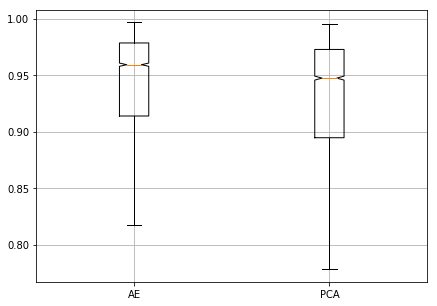

In [27]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754661536
AE 2.846862706297798


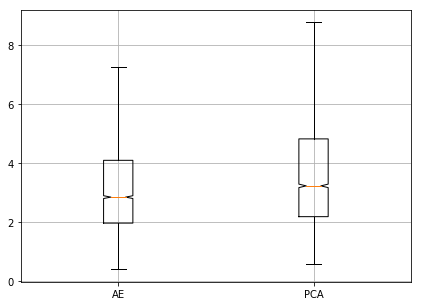

In [28]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Deep Encoder - Shallow Decoder Variation

In [22]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_var(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_var, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
                                     activation_layer,
                                     nn.Linear(10, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [30]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_var(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_var(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52, vlosses_52 = train_ae(ae_52, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_5_4', np.array(losses_54))
np.save('models/final_models/vlosses_5_2', np.array(vlosses_52))
np.save('models/final_models/losses_5_2', np.array(losses_52))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_5_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 18613
epoch [1/350000], loss:1679.81835938, val:992.41973877
epoch [101/350000], loss:1352.14318848, val:1176.63452148
epoch [201/350000], loss:523.39849854, val:562.90972900
epoch [301/350000], loss:265.54977417, val:224.34967041
epoch [401/350000], loss:235.06005859, val:254.35949707
epoch [501/350000], loss:187.22633362, val:191.91464233
epoch [601/350000], loss:164.85853577, val:214.70788574
epoch [701/350000], loss:144.16198730, val:116.66170502
epoch [801/350000], loss:144.19403076, val:169.47012329
epoch [901/350000], loss:152.10151672, val:144.06828308
epoch [1001/350000], loss:147.20324707, val:143.72012329
epoch [1101/350000], loss:150.22259521, val:148.44668579
epoch [1201/350000], loss:152.39302063, val:134.25158691
epoch [1301/350000], loss:139.43395996, val:152.22563171
epoch [1401/350000], loss:136.65351868, val:143.95899963
epoch [1501/350000], loss:141.57743835, val:124.79283142
epoch [1601/350000], loss:139.65887451, val:122.72951508
epoch 

epoch [14401/350000], loss:122.21502686, val:124.49629211
epoch [14501/350000], loss:115.48464966, val:110.08203888
epoch [14601/350000], loss:113.73524475, val:87.35881042
epoch [14701/350000], loss:121.34251404, val:116.29967499
epoch [14801/350000], loss:119.70210266, val:83.80453491
epoch [14901/350000], loss:115.14728546, val:141.37277222
epoch [15001/350000], loss:121.22653961, val:107.19032288
epoch [15101/350000], loss:125.33377075, val:94.19386292
epoch [15201/350000], loss:121.99217224, val:98.09625244
epoch [15301/350000], loss:114.56154633, val:88.37196350
epoch [15401/350000], loss:119.12245178, val:98.43251801
epoch [15501/350000], loss:117.87468719, val:87.76309967
epoch [15601/350000], loss:118.29454041, val:124.71046448
epoch [15701/350000], loss:122.88398743, val:112.30676270
epoch [15801/350000], loss:116.71218109, val:130.88339233
epoch [15901/350000], loss:115.76843262, val:95.24310303
epoch [16001/350000], loss:126.81076813, val:115.05692291
epoch [16101/350000], 

epoch [28701/350000], loss:129.73451233, val:83.03681183
epoch [28801/350000], loss:105.76545715, val:117.48572540
epoch [28901/350000], loss:115.95985413, val:97.04108429
epoch [29001/350000], loss:118.41245270, val:108.67806244
epoch [29101/350000], loss:103.04080200, val:105.70560455
epoch [29201/350000], loss:112.36017609, val:76.40108490
epoch [29301/350000], loss:114.99387360, val:88.54763031
epoch [29401/350000], loss:109.38791656, val:128.66838074
epoch [29501/350000], loss:106.77783966, val:144.89099121
epoch [29601/350000], loss:108.06010437, val:105.78746796
epoch [29701/350000], loss:108.05982208, val:89.11117554
epoch [29801/350000], loss:111.51798248, val:91.14778137
epoch [29901/350000], loss:111.54217529, val:96.59267426
epoch [30001/350000], loss:108.35715485, val:95.14910889
epoch [30101/350000], loss:106.75897217, val:103.78726959
epoch [30201/350000], loss:106.11364746, val:121.70693970
epoch [30301/350000], loss:118.70903015, val:150.57815552
epoch [30401/350000], 

epoch [43001/350000], loss:106.80671692, val:89.27515411
epoch [43101/350000], loss:107.04718018, val:127.26686859
epoch [43201/350000], loss:104.95194244, val:98.13927460
epoch [43301/350000], loss:112.28175354, val:97.83056641
epoch [43401/350000], loss:112.92860413, val:120.88169098
epoch [43501/350000], loss:109.32264709, val:93.88296509
epoch [43601/350000], loss:106.98506165, val:97.15940094
epoch [43701/350000], loss:119.06810760, val:88.46430206
epoch [43801/350000], loss:121.40013123, val:111.66967010
epoch [43901/350000], loss:104.59884644, val:133.66891479
epoch [44001/350000], loss:108.32378387, val:90.78280640
epoch [44101/350000], loss:109.82367706, val:108.20109558
epoch [44201/350000], loss:105.31238556, val:93.81030273
epoch [44301/350000], loss:106.47787476, val:126.42495728
epoch [44401/350000], loss:108.08316803, val:130.00825500
epoch [44501/350000], loss:114.63632202, val:98.35359955
epoch [44601/350000], loss:112.71794128, val:103.77966309
epoch [44701/350000], l

epoch [57301/350000], loss:107.47548676, val:131.83555603
epoch [57401/350000], loss:112.07601929, val:92.07614899
epoch [57501/350000], loss:103.43919373, val:99.92443085
epoch [57601/350000], loss:112.01688385, val:98.85634613
epoch [57701/350000], loss:103.78075409, val:102.10166931
epoch [57801/350000], loss:103.54927063, val:93.90673828
epoch [57901/350000], loss:100.61579132, val:98.49781036
epoch [58001/350000], loss:109.98384857, val:123.53245544
epoch [58101/350000], loss:106.08473969, val:133.14843750
epoch [58201/350000], loss:112.59268951, val:80.26765442
epoch [58301/350000], loss:114.29302216, val:100.28433990
epoch [58401/350000], loss:112.05615997, val:110.04358673
epoch [58501/350000], loss:109.45883179, val:139.50848389
epoch [58601/350000], loss:102.87126160, val:132.23854065
epoch [58701/350000], loss:103.42765045, val:119.54695892
epoch [58801/350000], loss:98.17967987, val:105.10313416
epoch [58901/350000], loss:101.80846405, val:83.48962402
epoch [59001/350000], 

epoch [71601/350000], loss:108.04851532, val:101.11363220
epoch [71701/350000], loss:109.21023560, val:93.48754883
epoch [71801/350000], loss:103.35346222, val:93.78661346
epoch [71901/350000], loss:101.36148834, val:87.16348267
epoch [72001/350000], loss:110.44922638, val:90.26464081
epoch [72101/350000], loss:108.07187653, val:95.23587799
epoch [72201/350000], loss:112.96952820, val:92.79280090
epoch [72301/350000], loss:116.80695343, val:91.53131104
epoch [72401/350000], loss:103.20735931, val:85.28453827
epoch [72501/350000], loss:104.63175964, val:99.96501160
epoch [72601/350000], loss:105.14646149, val:106.93778992
epoch [72701/350000], loss:103.47848511, val:107.79902649
epoch [72801/350000], loss:117.90212250, val:97.21437073
epoch [72901/350000], loss:108.71105957, val:115.95518494
epoch [73001/350000], loss:115.30670166, val:89.12617493
epoch [73101/350000], loss:102.66600037, val:124.30741119
epoch [73201/350000], loss:103.45391846, val:79.34613800
epoch [73301/350000], loss

epoch [85901/350000], loss:113.89018250, val:86.55500031
epoch [86001/350000], loss:110.74939728, val:117.45464325
epoch [86101/350000], loss:107.36596680, val:108.74771881
epoch [86201/350000], loss:106.03437805, val:93.50776672
epoch [86301/350000], loss:114.64577484, val:98.12979126
epoch [86401/350000], loss:106.29248047, val:79.35468292
epoch [86501/350000], loss:109.54918671, val:81.38737488
epoch [86601/350000], loss:109.03148651, val:97.66844177
epoch [86701/350000], loss:114.61680603, val:92.42964172
epoch [86801/350000], loss:105.24851227, val:83.16038513
epoch [86901/350000], loss:105.50227356, val:95.29630280
epoch [87001/350000], loss:102.36488342, val:105.32089996
epoch [87101/350000], loss:110.53276062, val:119.83688354
epoch [87201/350000], loss:110.93466949, val:84.28926086
epoch [87301/350000], loss:108.63671875, val:88.14022827
epoch [87401/350000], loss:108.76719666, val:96.76387024
epoch [87501/350000], loss:108.20890808, val:98.03263855
epoch [87601/350000], loss:

epoch [100201/350000], loss:103.48689270, val:130.91236877
epoch [100301/350000], loss:100.45375824, val:112.72746277
epoch [100401/350000], loss:106.72295380, val:155.69682312
epoch [100501/350000], loss:107.90219116, val:103.82984161
epoch [100601/350000], loss:104.25978851, val:109.47598267
epoch [100701/350000], loss:102.92679596, val:120.13186646
epoch [100801/350000], loss:108.89472961, val:133.79789734
epoch [100901/350000], loss:97.44387054, val:83.97885895
epoch [101001/350000], loss:115.61985779, val:93.50605011
epoch [101101/350000], loss:104.26931000, val:88.44802094
epoch [101201/350000], loss:106.94276428, val:121.28195190
epoch [101301/350000], loss:108.13434601, val:83.05264282
epoch [101401/350000], loss:117.50218201, val:98.98672485
epoch [101501/350000], loss:108.08843994, val:88.78875732
epoch [101601/350000], loss:107.95771027, val:83.60876465
epoch [101701/350000], loss:103.38159180, val:95.19658661
epoch [101801/350000], loss:108.47163391, val:84.66544342
epoch [

epoch [114301/350000], loss:115.49732208, val:119.52060699
epoch [114401/350000], loss:106.55640411, val:97.78408051
epoch [114501/350000], loss:103.57102203, val:142.88336182
epoch [114601/350000], loss:109.65497589, val:103.30509186
epoch [114701/350000], loss:105.06503296, val:83.68657684
epoch [114801/350000], loss:103.01895142, val:96.46736145
epoch [114901/350000], loss:99.61293793, val:92.13652039
epoch [115001/350000], loss:115.42120361, val:95.78696442
epoch [115101/350000], loss:104.08555603, val:87.17929840
epoch [115201/350000], loss:109.11124420, val:94.96956635
epoch [115301/350000], loss:106.25703430, val:103.21059418
epoch [115401/350000], loss:107.23736572, val:88.96116638
epoch [115501/350000], loss:104.50815582, val:92.59568024
epoch [115601/350000], loss:108.39947510, val:144.91667175
epoch [115701/350000], loss:102.18093872, val:87.99735260
epoch [115801/350000], loss:100.99477386, val:180.96986389
epoch [115901/350000], loss:102.93627167, val:142.54830933
epoch [1

epoch [128401/350000], loss:110.92465973, val:99.64472198
epoch [128501/350000], loss:103.62962341, val:179.85339355
epoch [128601/350000], loss:103.02553558, val:128.27726746
epoch [128701/350000], loss:105.34745026, val:108.11887360
epoch [128801/350000], loss:108.79668427, val:132.49501038
epoch [128901/350000], loss:105.19079590, val:112.59901428
epoch [129001/350000], loss:108.80944824, val:134.80371094
epoch [129101/350000], loss:107.48490143, val:102.43970490
epoch [129201/350000], loss:113.04544830, val:111.18947601
epoch [129301/350000], loss:115.07536316, val:92.15718079
epoch [129401/350000], loss:107.79222107, val:106.63259888
epoch [129501/350000], loss:111.30020905, val:86.32589722
epoch [129601/350000], loss:107.66191101, val:96.24310303
epoch [129701/350000], loss:110.57626343, val:107.42363739
epoch [129801/350000], loss:112.42539215, val:111.70639801
epoch [129901/350000], loss:101.27751923, val:134.42945862
epoch [130001/350000], loss:105.70939636, val:119.78730774
e

epoch [142501/350000], loss:105.79878998, val:90.98251343
epoch [142601/350000], loss:103.17520905, val:124.12828827
epoch [142701/350000], loss:104.41420746, val:73.42794037
epoch [142801/350000], loss:105.43922424, val:87.99365234
epoch [142901/350000], loss:106.90135956, val:97.18611908
epoch [143001/350000], loss:105.37738800, val:105.31355286
epoch [143101/350000], loss:105.47524261, val:95.22103119
epoch [143201/350000], loss:102.98461151, val:99.56324768
epoch [143301/350000], loss:104.02916718, val:90.84512329
epoch [143401/350000], loss:94.47637939, val:79.12651062
epoch [143501/350000], loss:108.90589905, val:97.21382904
epoch [143601/350000], loss:98.14475250, val:93.56534576
epoch [143701/350000], loss:108.74675751, val:94.10178375
epoch [143801/350000], loss:104.59187317, val:99.64302826
epoch [143901/350000], loss:98.95063019, val:101.12097168
epoch [144001/350000], loss:101.06416321, val:155.30859375
epoch [144101/350000], loss:106.29379272, val:88.59681702
epoch [144201

epoch [156601/350000], loss:98.09816742, val:103.09701538
epoch [156701/350000], loss:100.78746796, val:87.73174286
epoch [156801/350000], loss:102.28808594, val:90.80499268
epoch [156901/350000], loss:109.65283966, val:94.21163177
epoch [157001/350000], loss:101.37769318, val:88.76473999
epoch [157101/350000], loss:112.98531342, val:101.55562592
epoch [157201/350000], loss:104.48561859, val:93.01097870
epoch [157301/350000], loss:103.57160187, val:107.46770477
epoch [157401/350000], loss:99.72018433, val:99.83592224
epoch [157501/350000], loss:106.39710999, val:93.90663147
epoch [157601/350000], loss:105.87519073, val:83.53986359
epoch [157701/350000], loss:99.96484375, val:96.49098969
epoch [157801/350000], loss:101.98543549, val:91.78469849
epoch [157901/350000], loss:107.98454285, val:97.27822113
epoch [158001/350000], loss:95.34140778, val:97.98998260
epoch [158101/350000], loss:97.02367401, val:89.16500854
epoch [158201/350000], loss:102.04277039, val:80.75640869
epoch [158301/35

epoch [170701/350000], loss:105.21751404, val:86.75300598
epoch [170801/350000], loss:110.69680023, val:120.80028534
epoch [170901/350000], loss:109.35184479, val:117.44686127
epoch [171001/350000], loss:104.89418030, val:100.96594238
epoch [171101/350000], loss:97.71779633, val:85.58080292
epoch [171201/350000], loss:108.44762421, val:72.95906830
epoch [171301/350000], loss:104.09446716, val:125.70191956
epoch [171401/350000], loss:98.25767517, val:95.29632568
epoch [171501/350000], loss:106.35106659, val:93.54803467
epoch [171601/350000], loss:99.47071838, val:101.83823395
epoch [171701/350000], loss:102.06803894, val:135.39356995
epoch [171801/350000], loss:102.48223877, val:92.60862732
epoch [171901/350000], loss:107.47155762, val:91.28109741
epoch [172001/350000], loss:106.59184265, val:86.68449402
epoch [172101/350000], loss:105.50943756, val:103.84681702
epoch [172201/350000], loss:104.98854065, val:95.55753326
epoch [172301/350000], loss:101.54384613, val:92.39388275
epoch [172

epoch [184801/350000], loss:97.72024536, val:99.42434692
epoch [184901/350000], loss:104.30537415, val:82.04281616
epoch [185001/350000], loss:105.85025787, val:110.05462646
epoch [185101/350000], loss:98.82452393, val:89.89554596
epoch [185201/350000], loss:102.01728821, val:145.14488220
epoch [185301/350000], loss:96.81029510, val:105.96664429
epoch [185401/350000], loss:102.93174744, val:85.87377167
epoch [185501/350000], loss:104.65121460, val:95.11346436
epoch [185601/350000], loss:105.98484039, val:82.22221375
epoch [185701/350000], loss:104.06480408, val:99.60375977
epoch [185801/350000], loss:103.37684631, val:94.94149780
epoch [185901/350000], loss:105.32250214, val:99.33125305
epoch [186001/350000], loss:104.41724396, val:90.91931152
epoch [186101/350000], loss:98.12885284, val:121.90312958
epoch [186201/350000], loss:97.68656921, val:88.24285889
epoch [186301/350000], loss:103.67678070, val:101.30040741
epoch [186401/350000], loss:102.84003448, val:82.26200104
epoch [186501/

epoch [198901/350000], loss:102.77619171, val:117.13854218
epoch [199001/350000], loss:102.41465759, val:90.40679932
epoch [199101/350000], loss:96.99605560, val:119.36560822
epoch [199201/350000], loss:100.92433929, val:95.52542114
epoch [199301/350000], loss:106.54509735, val:96.18473053
epoch [199401/350000], loss:105.97347260, val:85.06246948
epoch [199501/350000], loss:113.93491364, val:96.94107819
epoch [199601/350000], loss:100.90905762, val:94.39984894
epoch [199701/350000], loss:112.08718872, val:90.40325165
epoch [199801/350000], loss:109.81208801, val:80.15539551
epoch [199901/350000], loss:112.52087402, val:85.89062500
epoch [200001/350000], loss:101.48023987, val:103.43247223
epoch [200101/350000], loss:104.02847290, val:99.45281982
epoch [200201/350000], loss:97.83565521, val:94.42806244
epoch [200301/350000], loss:104.49320984, val:94.60478210
epoch [200401/350000], loss:106.35807037, val:94.60960388
epoch [200501/350000], loss:107.12255096, val:86.35479736
epoch [200601

epoch [213101/350000], loss:103.98084259, val:91.60732269
epoch [213201/350000], loss:101.47242737, val:111.08258820
epoch [213301/350000], loss:105.15975189, val:95.32998657
epoch [213401/350000], loss:101.18711090, val:104.51676941
epoch [213501/350000], loss:101.04421234, val:90.77253723
epoch [213601/350000], loss:104.23928070, val:89.66228485
epoch [213701/350000], loss:99.88216400, val:91.49750519
epoch [213801/350000], loss:104.61024475, val:84.40237427
epoch [213901/350000], loss:98.10724640, val:93.50537872
epoch [214001/350000], loss:99.51630402, val:82.71098328
epoch [214101/350000], loss:99.13279724, val:86.29316711
epoch [214201/350000], loss:97.23272705, val:94.61832428
epoch [214301/350000], loss:102.51582336, val:91.87073517
epoch [214401/350000], loss:101.92697144, val:98.36746216
epoch [214501/350000], loss:101.60165405, val:105.16043091
epoch [214601/350000], loss:94.57534027, val:92.41344452
epoch [214701/350000], loss:97.39130402, val:106.37143707
epoch [214801/350

epoch [227301/350000], loss:100.97146606, val:96.00428009
epoch [227401/350000], loss:99.51577759, val:85.20028687
epoch [227501/350000], loss:101.00207520, val:85.99771881
epoch [227601/350000], loss:103.57467651, val:95.17645264
epoch [227701/350000], loss:102.51889801, val:104.10105896
epoch [227801/350000], loss:99.17100525, val:81.62371063
epoch [227901/350000], loss:99.61608124, val:80.80668640
epoch [228001/350000], loss:102.63477325, val:90.51953125
epoch [228101/350000], loss:101.60463715, val:85.95525360
epoch [228201/350000], loss:101.76050568, val:112.38097382
epoch [228301/350000], loss:98.10998535, val:84.87564087
epoch [228401/350000], loss:97.57492828, val:108.89998627
epoch [228501/350000], loss:100.95703125, val:82.22358704
epoch [228601/350000], loss:102.36822510, val:130.56317139
epoch [228701/350000], loss:108.25408173, val:87.02325439
epoch [228801/350000], loss:103.53616333, val:153.06465149
epoch [228901/350000], loss:103.05268097, val:81.37483215
epoch [229001/

epoch [241501/350000], loss:111.57877350, val:112.71818542
epoch [241601/350000], loss:112.51368713, val:91.98126221
epoch [241701/350000], loss:110.27212524, val:135.49932861
epoch [241801/350000], loss:112.28759003, val:100.28930664
epoch [241901/350000], loss:107.46170044, val:91.97599030
epoch [242001/350000], loss:99.50066376, val:108.44510651
epoch [242101/350000], loss:106.57783508, val:109.78252411
epoch [242201/350000], loss:104.53910065, val:116.55920410
epoch [242301/350000], loss:101.86965179, val:102.73157501
epoch [242401/350000], loss:105.87717438, val:96.83268738
epoch [242501/350000], loss:109.47911072, val:97.77183533
epoch [242601/350000], loss:109.66921234, val:105.56735992
epoch [242701/350000], loss:107.41201019, val:81.49467468
epoch [242801/350000], loss:97.49155426, val:73.72872925
epoch [242901/350000], loss:105.04827118, val:130.37606812
epoch [243001/350000], loss:104.84645081, val:104.61389923
epoch [243101/350000], loss:99.04315948, val:91.74340057
epoch [

epoch [255701/350000], loss:103.54904938, val:98.52725220
epoch [255801/350000], loss:102.97598267, val:97.00737000
epoch [255901/350000], loss:100.12156677, val:108.69033051
epoch [256001/350000], loss:100.30661011, val:106.46491241
epoch [256101/350000], loss:107.06000519, val:95.06547546
epoch [256201/350000], loss:102.93325043, val:84.32626343
epoch [256301/350000], loss:105.30606842, val:91.61009216
epoch [256401/350000], loss:101.95880890, val:92.63407135
epoch [256501/350000], loss:101.93314362, val:96.19819641
epoch [256601/350000], loss:102.14935303, val:93.30432892
epoch [256701/350000], loss:101.38637543, val:95.59307861
epoch [256801/350000], loss:102.49277496, val:87.70123291
epoch [256901/350000], loss:103.68534088, val:107.92438507
epoch [257001/350000], loss:102.64749146, val:110.74250793
epoch [257101/350000], loss:102.40836334, val:80.52806854
epoch [257201/350000], loss:105.99607849, val:79.88211060
epoch [257301/350000], loss:103.50073242, val:101.93521881
epoch [25

epoch [269901/350000], loss:107.36791992, val:93.19960022
epoch [270001/350000], loss:108.28187561, val:101.44891357
epoch [270101/350000], loss:98.75115967, val:96.01696014
epoch [270201/350000], loss:100.04831696, val:80.44396210
epoch [270301/350000], loss:95.05465698, val:84.99558258
epoch [270401/350000], loss:110.94760132, val:90.86634064
epoch [270501/350000], loss:103.09651947, val:101.60600281
epoch [270601/350000], loss:105.12568665, val:86.13220215
epoch [270701/350000], loss:104.17009735, val:103.72895813
epoch [270801/350000], loss:108.04537201, val:82.57940674
epoch [270901/350000], loss:108.11307526, val:100.87228394
epoch [271001/350000], loss:101.89801025, val:103.35087585
epoch [271101/350000], loss:107.95329285, val:101.08035278
epoch [271201/350000], loss:100.48120880, val:93.11357880
epoch [271301/350000], loss:99.21993256, val:103.66525269
epoch [271401/350000], loss:94.46298981, val:127.60643768
epoch [271501/350000], loss:106.19734192, val:94.43361664
epoch [271

epoch [284001/350000], loss:101.97748566, val:95.86275482
epoch [284101/350000], loss:96.99311829, val:88.77931976
epoch [284201/350000], loss:98.90549469, val:136.64849854
epoch [284301/350000], loss:97.87346649, val:98.00705719
epoch [284401/350000], loss:97.20564270, val:87.12235260
epoch [284501/350000], loss:98.76108551, val:96.65994263
epoch [284601/350000], loss:102.29868317, val:92.51766968
epoch [284701/350000], loss:105.12552643, val:93.84130096
epoch [284801/350000], loss:102.70268250, val:82.52069092
epoch [284901/350000], loss:101.35414124, val:95.57927704
epoch [285001/350000], loss:98.33364105, val:102.65115356
epoch [285101/350000], loss:98.44331360, val:80.50611877
epoch [285201/350000], loss:96.62285614, val:87.68566895
epoch [285301/350000], loss:100.56024170, val:84.68831635
epoch [285401/350000], loss:104.02481079, val:101.60521698
epoch [285501/350000], loss:109.53388977, val:102.62299347
epoch [285601/350000], loss:102.63386536, val:89.36477661
epoch [285701/3500

epoch [298201/350000], loss:104.57413483, val:113.10419464
epoch [298301/350000], loss:105.02697754, val:82.81200409
epoch [298401/350000], loss:104.60158539, val:83.16231537
epoch [298501/350000], loss:102.08444214, val:82.61061859
epoch [298601/350000], loss:94.54565430, val:137.70339966
epoch [298701/350000], loss:106.56603241, val:87.72316742
epoch [298801/350000], loss:105.45156097, val:94.06688690
epoch [298901/350000], loss:103.66333008, val:88.78556824
epoch [299001/350000], loss:97.15251923, val:75.15248871
epoch [299101/350000], loss:105.51580048, val:96.46269989
epoch [299201/350000], loss:102.72975159, val:123.16791534
epoch [299301/350000], loss:93.35551453, val:84.44834137
epoch [299401/350000], loss:96.73177338, val:97.00679779
epoch [299501/350000], loss:105.13786316, val:122.64553070
epoch [299601/350000], loss:96.34722900, val:92.66359711
epoch [299701/350000], loss:105.24612427, val:181.83146667
epoch [299801/350000], loss:108.58395386, val:82.41752625
epoch [299901/

epoch [312401/350000], loss:96.08363342, val:98.56839752
epoch [312501/350000], loss:102.19345856, val:111.44483948
epoch [312601/350000], loss:96.65224457, val:96.15455627
epoch [312701/350000], loss:100.18415070, val:102.39924622
epoch [312801/350000], loss:102.42989349, val:115.46105194
epoch [312901/350000], loss:98.82104492, val:125.95452118
epoch [313001/350000], loss:93.99626160, val:80.99440002
epoch [313101/350000], loss:98.35008240, val:93.10599518
epoch [313201/350000], loss:98.15619659, val:105.79985809
epoch [313301/350000], loss:103.70279694, val:83.09672546
epoch [313401/350000], loss:98.39464569, val:112.78130341
epoch [313501/350000], loss:101.31549072, val:94.16284943
epoch [313601/350000], loss:100.23516083, val:107.40264893
epoch [313701/350000], loss:103.86924744, val:91.89531708
epoch [313801/350000], loss:105.14393616, val:94.49797058
epoch [313901/350000], loss:102.60617828, val:105.04238129
epoch [314001/350000], loss:97.06142426, val:105.51661682
epoch [314101

epoch [326601/350000], loss:111.87918091, val:88.87303162
epoch [326701/350000], loss:104.57298279, val:91.56427002
epoch [326801/350000], loss:105.19709015, val:92.99465942
epoch [326901/350000], loss:107.03634644, val:94.58931732
epoch [327001/350000], loss:94.54699707, val:91.64601135
epoch [327101/350000], loss:102.07152557, val:94.66785431
epoch [327201/350000], loss:106.22813416, val:115.00460815
epoch [327301/350000], loss:106.95347595, val:91.96802521
epoch [327401/350000], loss:100.25665283, val:98.22920227
epoch [327501/350000], loss:98.71694946, val:97.47978210
epoch [327601/350000], loss:102.74398804, val:134.73588562
epoch [327701/350000], loss:104.74456787, val:83.30897522
epoch [327801/350000], loss:102.16498566, val:96.77342987
epoch [327901/350000], loss:100.22615051, val:78.31098938
epoch [328001/350000], loss:98.95668793, val:80.16418457
epoch [328101/350000], loss:101.73704529, val:100.55424500
epoch [328201/350000], loss:95.31945801, val:91.40242004
epoch [328301/3

epoch [340801/350000], loss:100.73780823, val:73.62768555
epoch [340901/350000], loss:106.54981995, val:86.93736267
epoch [341001/350000], loss:102.76741791, val:90.07015228
epoch [341101/350000], loss:100.41468048, val:86.17536926
epoch [341201/350000], loss:115.62820435, val:79.51277161
epoch [341301/350000], loss:102.14015961, val:85.83036041
epoch [341401/350000], loss:107.21877289, val:87.67038727
epoch [341501/350000], loss:111.02740479, val:90.21755219
epoch [341601/350000], loss:101.79850006, val:78.72898865
epoch [341701/350000], loss:102.83874512, val:92.19523621
epoch [341801/350000], loss:109.35711670, val:144.26536560
epoch [341901/350000], loss:98.02490234, val:86.88246155
epoch [342001/350000], loss:101.06581879, val:93.03610992
epoch [342101/350000], loss:101.33664703, val:79.14263153
epoch [342201/350000], loss:104.84616089, val:132.98588562
epoch [342301/350000], loss:100.96462250, val:132.04518127
epoch [342401/350000], loss:101.68994904, val:126.81491852
epoch [3425

In [31]:
ae_1 = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

AE 0.9583042206125387
PCA 0.9473133023945345


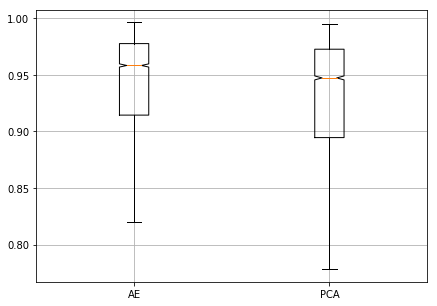

In [32]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754662336
AE 2.715969777608768


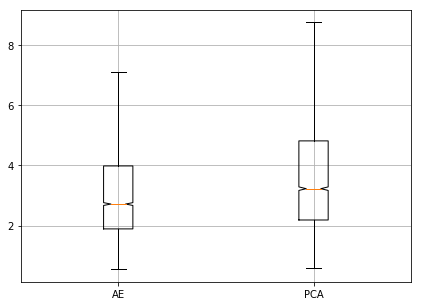

In [33]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# Super Deep Encoder

In [23]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_sdeep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sdeep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 80),
                                     activation_layer,
                                     nn.Linear(80, 60),
                                     activation_layer,
                                     nn.Linear(60, 45),
                                     activation_layer,
                                     nn.Linear(45, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, 8),
                                     activation_layer,
                                     nn.Linear(8, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 8),
                                     activation_layer,
                                     nn.Linear(8, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 45),
                                     activation_layer,
                                     nn.Linear(45, 60),
                                     activation_layer,
                                     nn.Linear(60, 80),
                                     activation_layer,
                                     nn.Linear(80, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [35]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_sdeep(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_sdeep(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52, vlosses_52 = train_ae(ae_52, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_6_4', np.array(losses_54))
np.save('models/final_models/vlosses_6_2', np.array(vlosses_52))
np.save('models/final_models/losses_6_2', np.array(losses_52))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_6_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_6_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 44987
epoch [1/350000], loss:1597.58349609, val:1510.63903809
epoch [101/350000], loss:607.38848877, val:604.86053467
epoch [201/350000], loss:232.45678711, val:178.00630188
epoch [301/350000], loss:224.67088318, val:196.73176575
epoch [401/350000], loss:229.04702759, val:176.47297668
epoch [501/350000], loss:233.50224304, val:298.84902954
epoch [601/350000], loss:222.48936462, val:192.61952209
epoch [701/350000], loss:226.78256226, val:228.87548828
epoch [801/350000], loss:222.37281799, val:196.96147156
epoch [901/350000], loss:229.76185608, val:191.87596130
epoch [1001/350000], loss:227.75830078, val:174.34658813
epoch [1101/350000], loss:173.30610657, val:143.93875122
epoch [1201/350000], loss:147.80604553, val:117.89859009
epoch [1301/350000], loss:139.19911194, val:103.53172302
epoch [1401/350000], loss:126.03913879, val:155.53285217
epoch [1501/350000], loss:138.76263428, val:114.08512878
epoch [1601/350000], loss:127.28918457, val:145.89065552
epoch [

epoch [14301/350000], loss:125.61125946, val:112.85799408
epoch [14401/350000], loss:117.12069702, val:151.88613892
epoch [14501/350000], loss:129.54878235, val:93.84664917
epoch [14601/350000], loss:127.30570984, val:121.96910095
epoch [14701/350000], loss:119.44068909, val:83.75497437
epoch [14801/350000], loss:129.27462769, val:101.48875427
epoch [14901/350000], loss:125.67439270, val:123.02919769
epoch [15001/350000], loss:134.41551208, val:96.20999908
epoch [15101/350000], loss:130.67369080, val:114.46814728
epoch [15201/350000], loss:122.73212433, val:115.19216919
epoch [15301/350000], loss:126.84783173, val:154.16738892
epoch [15401/350000], loss:117.19618988, val:114.66627502
epoch [15501/350000], loss:122.08072662, val:133.00500488
epoch [15601/350000], loss:121.89387512, val:111.39350891
epoch [15701/350000], loss:125.03041077, val:109.08898163
epoch [15801/350000], loss:127.43828583, val:82.48097229
epoch [15901/350000], loss:124.13103485, val:145.07917786
epoch [16001/35000

epoch [28501/350000], loss:126.66476440, val:105.35652161
epoch [28601/350000], loss:124.96932220, val:88.42779541
epoch [28701/350000], loss:133.26274109, val:88.18231964
epoch [28801/350000], loss:127.48052216, val:105.76039886
epoch [28901/350000], loss:120.73754883, val:106.49700928
epoch [29001/350000], loss:126.17578888, val:89.99717712
epoch [29101/350000], loss:119.56205750, val:106.70343018
epoch [29201/350000], loss:129.75735474, val:107.47882843
epoch [29301/350000], loss:117.83890533, val:97.62486267
epoch [29401/350000], loss:118.30011749, val:91.00884247
epoch [29501/350000], loss:127.71454620, val:110.78379059
epoch [29601/350000], loss:133.37715149, val:107.64580536
epoch [29701/350000], loss:123.44388580, val:92.25548553
epoch [29801/350000], loss:124.50256348, val:79.70502472
epoch [29901/350000], loss:126.57511902, val:116.77302551
epoch [30001/350000], loss:120.48558044, val:127.90384674
epoch [30101/350000], loss:122.16689301, val:114.52035522
epoch [30201/350000],

epoch [42801/350000], loss:106.67684937, val:116.26989746
epoch [42901/350000], loss:105.44723511, val:113.09473419
epoch [43001/350000], loss:110.21609497, val:109.20481873
epoch [43101/350000], loss:112.15018463, val:105.62306976
epoch [43201/350000], loss:105.08969879, val:132.20150757
epoch [43301/350000], loss:105.97436523, val:91.00131226
epoch [43401/350000], loss:108.66060638, val:95.46880341
epoch [43501/350000], loss:114.45428467, val:101.53851318
epoch [43601/350000], loss:106.34289551, val:112.20032501
epoch [43701/350000], loss:106.34273529, val:83.72972870
epoch [43801/350000], loss:109.40504456, val:119.49091339
epoch [43901/350000], loss:112.14884186, val:80.35040283
epoch [44001/350000], loss:110.42648315, val:90.43717194
epoch [44101/350000], loss:107.92327118, val:119.19782257
epoch [44201/350000], loss:114.99874115, val:109.66285706
epoch [44301/350000], loss:115.88550568, val:99.13136292
epoch [44401/350000], loss:116.66036224, val:113.47008514
epoch [44501/350000]

epoch [57101/350000], loss:104.25205231, val:108.64358521
epoch [57201/350000], loss:101.24596405, val:93.18108368
epoch [57301/350000], loss:106.01184845, val:106.05623627
epoch [57401/350000], loss:105.95464325, val:92.20928192
epoch [57501/350000], loss:99.90720367, val:85.87577820
epoch [57601/350000], loss:98.25405884, val:111.35823822
epoch [57701/350000], loss:105.68661499, val:131.48321533
epoch [57801/350000], loss:104.50635529, val:98.45170593
epoch [57901/350000], loss:102.54322052, val:83.65736389
epoch [58001/350000], loss:103.87119293, val:95.87510681
epoch [58101/350000], loss:100.88730621, val:102.31105804
epoch [58201/350000], loss:100.36526489, val:95.38855743
epoch [58301/350000], loss:106.20526123, val:90.20729065
epoch [58401/350000], loss:101.18595123, val:90.03515625
epoch [58501/350000], loss:103.11186218, val:88.88069916
epoch [58601/350000], loss:100.15213776, val:93.86832428
epoch [58701/350000], loss:105.64372253, val:113.72002411
epoch [58801/350000], loss:

epoch [71501/350000], loss:104.66815186, val:96.14913177
epoch [71601/350000], loss:109.75013733, val:107.59802246
epoch [71701/350000], loss:102.42346954, val:106.76582336
epoch [71801/350000], loss:101.69290924, val:95.25838470
epoch [71901/350000], loss:105.56398773, val:82.60132599
epoch [72001/350000], loss:97.42929077, val:97.59857178
epoch [72101/350000], loss:103.60296631, val:100.84837341
epoch [72201/350000], loss:106.63002014, val:99.14407349
epoch [72301/350000], loss:103.41952515, val:101.60523987
epoch [72401/350000], loss:103.65258026, val:86.26790619
epoch [72501/350000], loss:114.41266632, val:107.35369873
epoch [72601/350000], loss:105.24279785, val:92.01319885
epoch [72701/350000], loss:103.22940826, val:87.23952484
epoch [72801/350000], loss:99.70317078, val:115.70931244
epoch [72901/350000], loss:112.35395050, val:88.10611725
epoch [73001/350000], loss:110.42240143, val:109.39147949
epoch [73101/350000], loss:104.72372437, val:86.30934143
epoch [73201/350000], loss

epoch [85901/350000], loss:103.27816010, val:87.78872681
epoch [86001/350000], loss:101.06465912, val:87.79008484
epoch [86101/350000], loss:107.11785889, val:89.87216949
epoch [86201/350000], loss:102.36651611, val:113.41434479
epoch [86301/350000], loss:100.88936615, val:102.56211090
epoch [86401/350000], loss:95.95777893, val:80.65248108
epoch [86501/350000], loss:103.05490875, val:76.05501556
epoch [86601/350000], loss:100.01129913, val:103.93186188
epoch [86701/350000], loss:102.11435699, val:126.50416565
epoch [86801/350000], loss:104.04159546, val:117.41114807
epoch [86901/350000], loss:99.82659912, val:71.22266388
epoch [87001/350000], loss:99.86948395, val:96.41738129
epoch [87101/350000], loss:95.09686279, val:87.91510010
epoch [87201/350000], loss:104.09751892, val:82.74226379
epoch [87301/350000], loss:100.68303680, val:84.64959717
epoch [87401/350000], loss:104.42906189, val:84.62162781
epoch [87501/350000], loss:96.06007385, val:123.92919922
epoch [87601/350000], loss:99.

epoch [100301/350000], loss:93.57340240, val:81.21566772
epoch [100401/350000], loss:101.07024384, val:90.23387146
epoch [100501/350000], loss:99.57075500, val:95.63866425
epoch [100601/350000], loss:94.92987823, val:88.49279785
epoch [100701/350000], loss:96.91681671, val:100.38526154
epoch [100801/350000], loss:111.47063446, val:107.00300598
epoch [100901/350000], loss:107.95663452, val:89.85252380
epoch [101001/350000], loss:105.07390594, val:89.89443970
epoch [101101/350000], loss:100.34002686, val:68.68434906
epoch [101201/350000], loss:101.44019318, val:109.68460083
epoch [101301/350000], loss:94.25337982, val:98.77650452
epoch [101401/350000], loss:112.80144501, val:96.05570221
epoch [101501/350000], loss:98.69697571, val:90.35675812
epoch [101601/350000], loss:97.29510498, val:112.80470276
epoch [101701/350000], loss:101.78358459, val:139.43606567
epoch [101801/350000], loss:101.58875275, val:81.04520416
epoch [101901/350000], loss:98.46611023, val:92.49917603
epoch [102001/350

epoch [114501/350000], loss:100.40493774, val:101.16789246
epoch [114601/350000], loss:103.02114105, val:91.30016327
epoch [114701/350000], loss:102.63194275, val:125.30288696
epoch [114801/350000], loss:97.83921051, val:105.63121796
epoch [114901/350000], loss:101.49324799, val:94.69212341
epoch [115001/350000], loss:97.09983826, val:101.76181793
epoch [115101/350000], loss:106.73024750, val:86.04825592
epoch [115201/350000], loss:98.91204071, val:96.74485016
epoch [115301/350000], loss:103.15232849, val:93.22804260
epoch [115401/350000], loss:107.46109772, val:86.68995667
epoch [115501/350000], loss:102.45507050, val:109.23601532
epoch [115601/350000], loss:100.33905029, val:94.59026337
epoch [115701/350000], loss:105.27974701, val:87.18331909
epoch [115801/350000], loss:103.50004578, val:71.89383698
epoch [115901/350000], loss:102.32144165, val:87.30281067
epoch [116001/350000], loss:96.90216064, val:92.93995667
epoch [116101/350000], loss:95.23300934, val:99.65379333
epoch [116201/

epoch [128701/350000], loss:95.90190887, val:100.49073792
epoch [128801/350000], loss:102.51007843, val:89.74408722
epoch [128901/350000], loss:110.61169434, val:79.45425415
epoch [129001/350000], loss:94.24989319, val:89.97715759
epoch [129101/350000], loss:98.23104858, val:124.33499146
epoch [129201/350000], loss:96.29569244, val:80.60530090
epoch [129301/350000], loss:104.74838257, val:95.75747681
epoch [129401/350000], loss:100.46503448, val:82.70252991
epoch [129501/350000], loss:100.35429382, val:96.93238831
epoch [129601/350000], loss:104.43987274, val:135.64901733
epoch [129701/350000], loss:101.41601562, val:88.86736298
epoch [129801/350000], loss:101.74217987, val:73.53327179
epoch [129901/350000], loss:100.30479431, val:95.68240356
epoch [130001/350000], loss:96.75560760, val:93.37265015
epoch [130101/350000], loss:96.75107574, val:90.35386658
epoch [130201/350000], loss:97.00730896, val:82.26679993
epoch [130301/350000], loss:94.93924713, val:100.07248688
epoch [130401/3500

epoch [142901/350000], loss:107.14357758, val:118.29208374
epoch [143001/350000], loss:110.88623810, val:98.81092072
epoch [143101/350000], loss:109.88403320, val:96.35932922
epoch [143201/350000], loss:103.21065521, val:125.03610229
epoch [143301/350000], loss:94.85650635, val:88.92964172
epoch [143401/350000], loss:104.27869415, val:72.54623413
epoch [143501/350000], loss:101.67540741, val:91.88555908
epoch [143601/350000], loss:99.32261658, val:101.32043457
epoch [143701/350000], loss:97.82560730, val:127.82148743
epoch [143801/350000], loss:102.64864349, val:79.40277863
epoch [143901/350000], loss:99.20166016, val:92.76971436
epoch [144001/350000], loss:105.80523682, val:91.20522308
epoch [144101/350000], loss:102.93877411, val:82.01930237
epoch [144201/350000], loss:98.41409302, val:89.86831665
epoch [144301/350000], loss:102.19277954, val:87.40322113
epoch [144401/350000], loss:99.98371124, val:84.41862488
epoch [144501/350000], loss:102.02339935, val:82.02285767
epoch [144601/35

epoch [157101/350000], loss:101.19328308, val:82.67132568
epoch [157201/350000], loss:103.33946991, val:98.71931458
epoch [157301/350000], loss:98.11442566, val:82.96026611
epoch [157401/350000], loss:100.55596161, val:109.43209839
epoch [157501/350000], loss:99.22874451, val:103.72782135
epoch [157601/350000], loss:104.65315247, val:84.44994354
epoch [157701/350000], loss:103.53635406, val:75.69255829
epoch [157801/350000], loss:101.32580566, val:145.68786621
epoch [157901/350000], loss:98.06758881, val:95.28204346
epoch [158001/350000], loss:99.65267181, val:96.47965240
epoch [158101/350000], loss:102.41255188, val:99.01024628
epoch [158201/350000], loss:100.61263275, val:104.94675446
epoch [158301/350000], loss:98.40921783, val:112.90473938
epoch [158401/350000], loss:95.36793518, val:98.46615601
epoch [158501/350000], loss:98.51123810, val:79.21846008
epoch [158601/350000], loss:100.76438141, val:102.33385468
epoch [158701/350000], loss:99.60050964, val:93.00386047
epoch [158801/35

epoch [171301/350000], loss:103.91709137, val:92.73450470
epoch [171401/350000], loss:102.41188049, val:99.41931915
epoch [171501/350000], loss:115.43766022, val:83.22824097
epoch [171601/350000], loss:103.88803864, val:89.25426483
epoch [171701/350000], loss:101.26272583, val:110.47855377
epoch [171801/350000], loss:105.50491333, val:115.19953156
epoch [171901/350000], loss:109.90821838, val:76.81751251
epoch [172001/350000], loss:104.04718781, val:78.79738617
epoch [172101/350000], loss:99.37273407, val:94.15197754
epoch [172201/350000], loss:104.84047699, val:93.83911133
epoch [172301/350000], loss:103.68720245, val:89.75936127
epoch [172401/350000], loss:109.62683105, val:90.56103516
epoch [172501/350000], loss:103.45954132, val:111.27086639
epoch [172601/350000], loss:104.72775269, val:98.36962891
epoch [172701/350000], loss:105.70141602, val:99.85598755
epoch [172801/350000], loss:102.39990234, val:81.51655579
epoch [172901/350000], loss:103.14561462, val:120.73413086
epoch [1730

epoch [185501/350000], loss:99.89559174, val:95.83515167
epoch [185601/350000], loss:100.01858521, val:117.43972778
epoch [185701/350000], loss:102.81056976, val:83.32995605
epoch [185801/350000], loss:97.59909821, val:108.78540039
epoch [185901/350000], loss:100.71205902, val:97.13692474
epoch [186001/350000], loss:95.83079529, val:79.41094971
epoch [186101/350000], loss:100.34135437, val:81.40026855
epoch [186201/350000], loss:96.58032990, val:84.96587372
epoch [186301/350000], loss:101.89195251, val:99.66440582
epoch [186401/350000], loss:94.51114655, val:79.43902588
epoch [186501/350000], loss:96.16520691, val:103.98054504
epoch [186601/350000], loss:109.01626587, val:91.75122833
epoch [186701/350000], loss:107.91925049, val:93.54018402
epoch [186801/350000], loss:107.30485535, val:93.81410980
epoch [186901/350000], loss:102.32023621, val:82.79774475
epoch [187001/350000], loss:100.79793549, val:69.94041443
epoch [187101/350000], loss:101.99827576, val:94.38074493
epoch [187201/350

epoch [199701/350000], loss:95.55652618, val:74.20414734
epoch [199801/350000], loss:104.31880951, val:82.03153229
epoch [199901/350000], loss:96.67735291, val:103.37334442
epoch [200001/350000], loss:97.49205780, val:88.07351685
epoch [200101/350000], loss:99.37841034, val:103.91453552
epoch [200201/350000], loss:97.48410797, val:78.57063293
epoch [200301/350000], loss:99.59542847, val:89.87040710
epoch [200401/350000], loss:99.86627960, val:84.18953705
epoch [200501/350000], loss:100.18091583, val:95.88323975
epoch [200601/350000], loss:101.59651947, val:128.25201416
epoch [200701/350000], loss:106.33639526, val:92.83053589
epoch [200801/350000], loss:98.68120575, val:103.51068878
epoch [200901/350000], loss:96.72322083, val:83.78150940
epoch [201001/350000], loss:96.46208191, val:92.82660675
epoch [201101/350000], loss:97.31243134, val:87.42385101
epoch [201201/350000], loss:96.66969299, val:89.19550323
epoch [201301/350000], loss:102.46894836, val:70.34159851
epoch [201401/350000],

epoch [214001/350000], loss:95.74078369, val:88.12596893
epoch [214101/350000], loss:101.32360840, val:69.84609222
epoch [214201/350000], loss:98.65974426, val:152.85353088
epoch [214301/350000], loss:100.54821777, val:94.49088287
epoch [214401/350000], loss:98.42503357, val:91.05311584
epoch [214501/350000], loss:96.07035065, val:85.47019196
epoch [214601/350000], loss:98.21620178, val:100.27046204
epoch [214701/350000], loss:100.47895050, val:91.69778442
epoch [214801/350000], loss:97.92230225, val:104.30256653
epoch [214901/350000], loss:101.46032715, val:76.45149994
epoch [215001/350000], loss:96.38317871, val:84.89498901
epoch [215101/350000], loss:93.80416870, val:73.02932739
epoch [215201/350000], loss:96.85183716, val:128.21829224
epoch [215301/350000], loss:97.39981842, val:77.43733215
epoch [215401/350000], loss:96.12415314, val:86.06233978
epoch [215501/350000], loss:92.77867889, val:99.76606750
epoch [215601/350000], loss:103.40142059, val:80.64435577
epoch [215701/350000],

epoch [228301/350000], loss:105.08408356, val:93.51857758
epoch [228401/350000], loss:105.82670593, val:92.55624390
epoch [228501/350000], loss:98.24696350, val:103.13806152
epoch [228601/350000], loss:100.49142456, val:96.47003174
epoch [228701/350000], loss:102.71147919, val:115.48934174
epoch [228801/350000], loss:103.21335602, val:90.31398773
epoch [228901/350000], loss:95.62604523, val:90.58753967
epoch [229001/350000], loss:108.47855377, val:107.84320068
epoch [229101/350000], loss:100.59998322, val:85.07005310
epoch [229201/350000], loss:98.27673340, val:89.12521362
epoch [229301/350000], loss:98.75641632, val:92.47930145
epoch [229401/350000], loss:95.13893890, val:82.95996857
epoch [229501/350000], loss:99.81320190, val:92.81121063
epoch [229601/350000], loss:99.20004272, val:117.00598145
epoch [229701/350000], loss:94.69985199, val:80.09597015
epoch [229801/350000], loss:94.96897125, val:102.63540649
epoch [229901/350000], loss:102.36823273, val:85.90737152
epoch [230001/3500

epoch [242601/350000], loss:103.21092987, val:84.62562561
epoch [242701/350000], loss:101.11111450, val:94.90280151
epoch [242801/350000], loss:101.00546265, val:114.63744354
epoch [242901/350000], loss:104.71401215, val:95.77446747
epoch [243001/350000], loss:107.36414337, val:120.08805847
epoch [243101/350000], loss:96.47286987, val:92.62586212
epoch [243201/350000], loss:101.09510040, val:93.74209595
epoch [243301/350000], loss:97.69743347, val:76.38417053
epoch [243401/350000], loss:98.22436523, val:118.93874359
epoch [243501/350000], loss:101.01348114, val:92.54153442
epoch [243601/350000], loss:97.50840759, val:91.09440613
epoch [243701/350000], loss:105.55442047, val:93.08821869
epoch [243801/350000], loss:99.62876892, val:121.41210938
epoch [243901/350000], loss:100.69635773, val:112.23299408
epoch [244001/350000], loss:102.79760742, val:101.35894775
epoch [244101/350000], loss:101.76581573, val:98.88648224
epoch [244201/350000], loss:104.10597992, val:86.23050690
epoch [244301

epoch [256801/350000], loss:104.61722565, val:91.46950531
epoch [256901/350000], loss:103.36034393, val:119.55414581
epoch [257001/350000], loss:104.79537201, val:87.25999451
epoch [257101/350000], loss:101.58895111, val:116.69662476
epoch [257201/350000], loss:95.84751129, val:79.39730072
epoch [257301/350000], loss:97.78559113, val:102.46756744
epoch [257401/350000], loss:97.33650970, val:85.98112488
epoch [257501/350000], loss:95.27820587, val:90.73862457
epoch [257601/350000], loss:97.88326263, val:103.35968781
epoch [257701/350000], loss:106.43290710, val:97.24917603
epoch [257801/350000], loss:97.90857697, val:113.16871643
epoch [257901/350000], loss:107.22983551, val:102.73162842
epoch [258001/350000], loss:103.40628052, val:83.62357330
epoch [258101/350000], loss:101.98719025, val:121.31044769
epoch [258201/350000], loss:95.95327759, val:108.17436981
epoch [258301/350000], loss:100.18296051, val:96.85370636
epoch [258401/350000], loss:98.65849304, val:97.32730865
epoch [258501/

epoch [271101/350000], loss:99.12018585, val:92.85012054
epoch [271201/350000], loss:95.32808685, val:95.47617340
epoch [271301/350000], loss:96.83200836, val:88.29509735
epoch [271401/350000], loss:106.02564240, val:83.34040833
epoch [271501/350000], loss:100.02130890, val:80.23971558
epoch [271601/350000], loss:98.93261719, val:81.96608734
epoch [271701/350000], loss:91.43359375, val:90.13935089
epoch [271801/350000], loss:99.96202850, val:94.03014374
epoch [271901/350000], loss:97.86672974, val:87.98275757
epoch [272001/350000], loss:92.58780670, val:125.20412445
epoch [272101/350000], loss:97.22631073, val:109.84349060
epoch [272201/350000], loss:100.80146790, val:102.89952850
epoch [272301/350000], loss:101.75447845, val:90.49742889
epoch [272401/350000], loss:101.60537720, val:88.16719818
epoch [272501/350000], loss:95.20575714, val:85.30034637
epoch [272601/350000], loss:100.60952759, val:93.12702942
epoch [272701/350000], loss:98.43297577, val:98.49364471
epoch [272801/350000],

epoch [285401/350000], loss:99.28485107, val:89.24103546
epoch [285501/350000], loss:97.47280884, val:90.41769409
epoch [285601/350000], loss:101.76393890, val:72.97079468
epoch [285701/350000], loss:96.97869110, val:92.44008636
epoch [285801/350000], loss:92.35137939, val:110.32779694
epoch [285901/350000], loss:97.29267883, val:90.98291779
epoch [286001/350000], loss:95.92343903, val:96.40096283
epoch [286101/350000], loss:100.07355499, val:92.27774811
epoch [286201/350000], loss:101.66019440, val:85.97155762
epoch [286301/350000], loss:94.11988831, val:116.92032623
epoch [286401/350000], loss:94.20992279, val:95.85948944
epoch [286501/350000], loss:97.08763123, val:82.89834595
epoch [286601/350000], loss:99.09558105, val:100.78495026
epoch [286701/350000], loss:96.20283508, val:86.30471039
epoch [286801/350000], loss:95.26277161, val:89.03058624
epoch [286901/350000], loss:95.83161926, val:99.10793304
epoch [287001/350000], loss:95.55316925, val:84.30643463
epoch [287101/350000], lo

epoch [299701/350000], loss:95.84388733, val:99.69180298
epoch [299801/350000], loss:96.40256500, val:81.15686035
epoch [299901/350000], loss:98.56437683, val:100.60684204
epoch [300001/350000], loss:98.75601196, val:99.53284454
epoch [300101/350000], loss:97.42101288, val:96.12814331
epoch [300201/350000], loss:103.23037720, val:81.13946533
epoch [300301/350000], loss:96.85390472, val:79.89393616
epoch [300401/350000], loss:101.00901031, val:81.91217804
epoch [300501/350000], loss:98.53060913, val:79.35115814
epoch [300601/350000], loss:94.90761566, val:117.18910980
epoch [300701/350000], loss:94.16500092, val:109.30915833
epoch [300801/350000], loss:93.88764954, val:92.05813599
epoch [300901/350000], loss:97.41848755, val:85.81153870
epoch [301001/350000], loss:95.53738403, val:89.91980743
epoch [301101/350000], loss:99.51993561, val:86.53945923
epoch [301201/350000], loss:99.62935638, val:91.15931702
epoch [301301/350000], loss:97.27633667, val:82.27951813
epoch [301401/350000], los

epoch [314001/350000], loss:97.54302216, val:85.29724884
epoch [314101/350000], loss:96.99375916, val:93.02651978
epoch [314201/350000], loss:102.86359406, val:93.17200470
epoch [314301/350000], loss:98.18344879, val:73.79154205
epoch [314401/350000], loss:98.82395172, val:96.31667328
epoch [314501/350000], loss:98.36795807, val:89.22441101
epoch [314601/350000], loss:97.90196228, val:77.69058228
epoch [314701/350000], loss:99.02138519, val:82.05312347
epoch [314801/350000], loss:97.23732758, val:96.70739746
epoch [314901/350000], loss:106.18717957, val:92.05938721
epoch [315001/350000], loss:100.72612000, val:108.10195160
epoch [315101/350000], loss:96.43119812, val:100.99457550
epoch [315201/350000], loss:94.47256470, val:81.46890259
epoch [315301/350000], loss:100.44169617, val:111.05816650
epoch [315401/350000], loss:104.71205902, val:103.97517395
epoch [315501/350000], loss:98.39792633, val:114.73465729
epoch [315601/350000], loss:103.02514648, val:99.44512939
epoch [315701/350000

epoch [328301/350000], loss:94.85931396, val:85.35559082
epoch [328401/350000], loss:95.33492279, val:103.28787231
epoch [328501/350000], loss:94.17819977, val:79.34407043
epoch [328601/350000], loss:95.91560364, val:162.37510681
epoch [328701/350000], loss:100.69422913, val:84.16239166
epoch [328801/350000], loss:101.44432068, val:95.10230255
epoch [328901/350000], loss:98.73364258, val:104.39691162
epoch [329001/350000], loss:103.92620850, val:65.42180634
epoch [329101/350000], loss:99.56487274, val:81.63796997
epoch [329201/350000], loss:97.62696838, val:88.36045837
epoch [329301/350000], loss:101.35888672, val:107.49993134
epoch [329401/350000], loss:99.86014557, val:111.25959778
epoch [329501/350000], loss:96.39894104, val:77.71140289
epoch [329601/350000], loss:100.02153778, val:77.20181274
epoch [329701/350000], loss:108.43066406, val:97.11731720
epoch [329801/350000], loss:101.62676239, val:92.46881104
epoch [329901/350000], loss:99.56652069, val:79.26151276
epoch [330001/35000

epoch [342501/350000], loss:97.28679657, val:86.80133057
epoch [342601/350000], loss:105.72969818, val:123.95196533
epoch [342701/350000], loss:99.39900208, val:79.76679993
epoch [342801/350000], loss:102.43226624, val:94.97920990
epoch [342901/350000], loss:105.04541016, val:91.03450775
epoch [343001/350000], loss:100.74266052, val:77.53566742
epoch [343101/350000], loss:101.26720428, val:101.11759949
epoch [343201/350000], loss:103.42806244, val:84.54120636
epoch [343301/350000], loss:102.15904999, val:77.33953094
epoch [343401/350000], loss:96.67549133, val:119.20050812
epoch [343501/350000], loss:99.87899780, val:80.56202698
epoch [343601/350000], loss:101.43972015, val:71.05114746
epoch [343701/350000], loss:101.99593353, val:92.33727264
epoch [343801/350000], loss:98.60273743, val:80.45120239
epoch [343901/350000], loss:104.57867432, val:120.39911652
epoch [344001/350000], loss:101.51094818, val:92.10436249
epoch [344101/350000], loss:101.45929718, val:90.10345459
epoch [344201/3

In [36]:
ae_1 = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_6_4.pt', map_location=lambda storage, loc: storage)

AE 0.958274180962378
PCA 0.9473133023945339
Baseline 0.9406087594335943


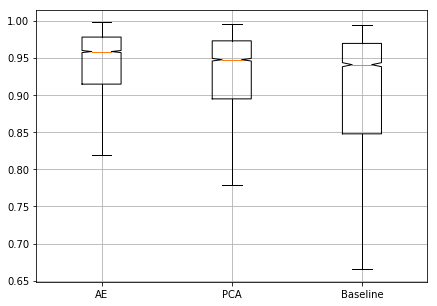

In [37]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca, "Baseline": comp_pca(0)}
find_correlation_coeff(d)

In [38]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')

PCA 3.2281291754662043
AE 2.8023538603597147
Baseline 10.523882220300688


PCA 3.2281291754662043
AE 2.8023538603597147
Baseline 10.523882220300688


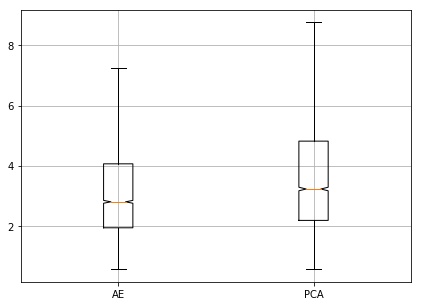

In [39]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

In [40]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [41]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

AE 0.958274180962378
PCA 0.9473133023945339
Baseline 0.9406087594335943
[('AE', 0.958274180962378), ('PCA', 0.9473133023945339), ('Baseline', 0.9406087594335943)]
Baseline Value:  0.9406087594335943
AE Value:  0.958274180962378
PCA Value:  0.9473133023945339

 AE improvement:  1.8780838846771182
PCA improvement:  0.7127876381862375


In [42]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

Baseline Value:  10.523882220300688
AE Value:  2.8023538603597147
PCA Value:  3.2281291754662043

 AE improvement:  73.37148210425671
PCA improvement:  69.32568126580601


# Asymmetric Single Decoder

In [24]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_sd(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sd, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 51))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_var(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_82 = autoencoder_sd(length, embedding_size).cuda()
ae_82.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_82.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_82, vlosses_82 = train_ae(ae_82, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
#np.save('models/final_models/losses_5_4', np.array(losses_54))
np.save('models/final_models/vlosses_8_2', np.array(vlosses_82))
np.save('models/final_models/losses_8_2', np.array(losses_82))


# Saving Models
#torch.save(ae_54, 'models/final_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_82, 'models/final_models/ae_8_2.pt') #Saving the autoencoder model

ae_1 = torch.load('models/final_models/ae_8_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

TOTAL PARAMETERS FOR MODEL: 12250
epoch [1/350000], loss:1548.97656250, val:1864.04187012
epoch [101/350000], loss:1556.33959961, val:1260.74279785
epoch [201/350000], loss:1431.28234863, val:1261.68774414
epoch [301/350000], loss:1410.15209961, val:1362.81665039


KeyboardInterrupt: 

In [25]:
sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single = None, None, None, None, None

In [26]:
def load_all_models():
    global sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single
    sym_deepest = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
    sym_deep = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
    sym_shallow = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
    
    asym_mult = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
    asym_single = torch.load('models/final_models/ae_8_2.pt', map_location=lambda storage, loc: storage)

In [27]:
load_all_models()

In [28]:
def find_cor_and_mse(ae):
    _, out_ae = get_network_output(ae, 2)
    ae_mse, mse_med = find_scaled_mse(electrode_data_test, out_ae)
    a, b = find_correlation_coeff({'AE': out_ae}, plot=False)
    ae_cor_med = a[0][1]
    ae_corrs = np.array(b['AE'])
    return ae_mse, ae_corrs, mse_med, ae_cor_med

In [29]:
find_cor_and_mse(sym_deepest)

(array([1.8858232 , 2.04179056, 4.68875036, ..., 1.04496709, 1.88495394,
        1.71071748]),
 array([0.97139981, 0.9724059 , 0.93931084, ..., 0.98906422, 0.95681946,
        0.96757187]),
 2.8023538603597147,
 0.958274180962378)

In [70]:
# Asym Single: 12250
# Asym Multi: 18613
# Sym Superdeep: 44987
# Sym Deep: 23775
# Sym Shallow: 6525

In [30]:
out_pca = comp_pca(2)
pca_mse, pca_med = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
a, b = find_correlation_coeff({'PCA': out_pca}, plot=False)
pca_cor_med = a[0][1]
pca_corrs = np.array(b['PCA'])

PCA 3.2281291754661194


In [31]:
out_base = comp_pca(0)
base_mse, base_med = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
a, b = find_correlation_coeff({'Baseline': out_base}, plot=False)
base_cor_med = a[0][1]
base_corrs = np.array(b['Baseline'])

Baseline 10.204287245214399


In [32]:
#sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single = None, None, None, None, None

ae_1_mse, ae_1_cor, ae_1_mse_med, ae_1_cor_med = find_cor_and_mse(sym_shallow)
ae_2_mse, ae_2_cor, ae_2_mse_med, ae_2_cor_med = find_cor_and_mse(sym_deep)
ae_3_mse, ae_3_cor, ae_3_mse_med, ae_3_cor_med = find_cor_and_mse(sym_deepest)
ae_4_mse, ae_4_cor, ae_4_mse_med, ae_4_cor_med = find_cor_and_mse(asym_single)
ae_5_mse, ae_5_cor, ae_5_mse_med, ae_5_cor_med = find_cor_and_mse(asym_mult)

# MSE Boxplots

In [113]:
dict_of_mse = {"Sym. AE \n(6525)": ae_1_mse, "Sym. AE \n(23775)": ae_2_mse, "Sym. AE \n(44987)": ae_3_mse, 
               "Asym. AE \n(12250)": ae_4_mse, "Asym. AE \n(18613)": ae_5_mse, "PCA": pca_mse, "Baseline": base_mse}

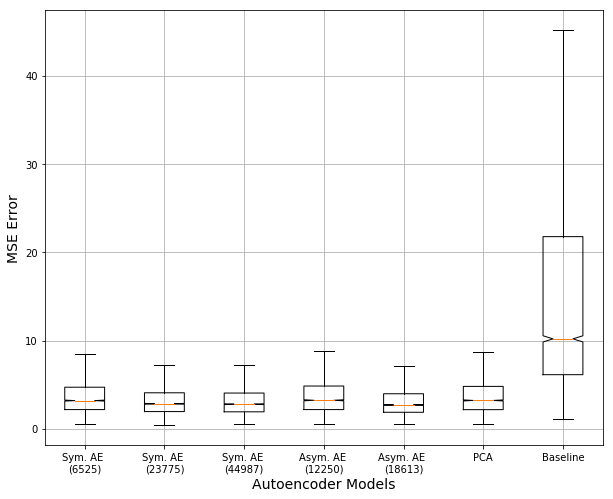

In [114]:
gen_boxplots(dict_of_mse, filename="lstm_mse_box.png", figsize=(10, 8), ylabel="MSE Error")

In [119]:
dict_of_mse = {"Sym. AE \n(6525)": ae_1_mse, "Sym. AE \n(23775)": ae_2_mse, "Sym. AE \n(44987)": ae_3_mse, 
               "Asym. AE \n(12250)": ae_4_mse, "Asym. AE \n(18613)": ae_5_mse, "PCA": pca_mse}

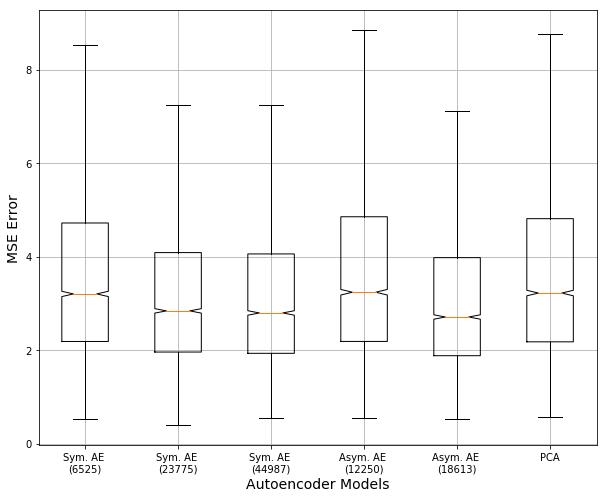

In [120]:
gen_boxplots(dict_of_mse, filename="lstm_mse_nobase_box.png", figsize=(10, 8), ylabel="MSE Error")

# Correlation Plots

In [117]:
dict_of_cor = {"Sym. AE \n(6525)": ae_1_cor, "Sym. AE \n(23775)": ae_2_cor, "Sym. AE \n(44987)": ae_3_cor, 
               "Asym. AE \n(12250)": ae_4_cor, "Asym. AE \n(18613)": ae_5_cor, "PCA": pca_corrs, "Baseline": base_corrs}

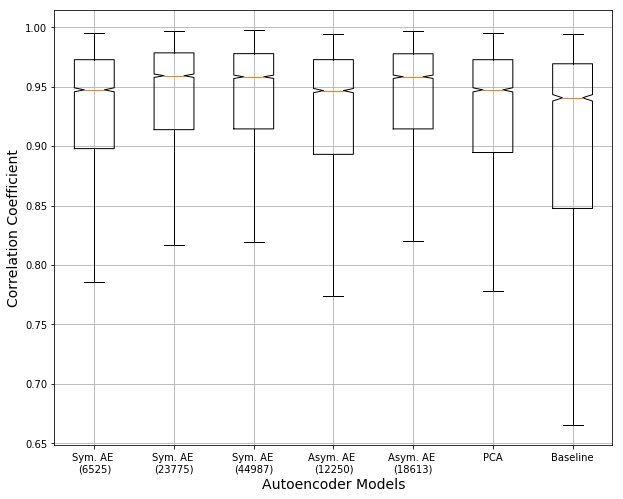

In [118]:
gen_boxplots(dict_of_cor, filename="correlation_box.png", figsize=(10, 8), ylabel="Correlation Coefficient")

In [109]:
print("Sym. AE (6525) & ", ae_1_mse_med, "\nSym. AE (23775) & ", ae_2_mse_med, "\nSym. AE (44987) & ", ae_3_mse_med, 
        "\nAsym. AE (12250) & ", ae_4_mse_med, "\nAsym. AE (18613) & ", ae_5_mse_med, "\nPCA & ", pca_med, 
      "\nBaseline & ", base_med)

Sym. AE (6525) &  3.2096299964494976 
Sym. AE (23775) &  2.846862706297798 
Sym. AE (44987) &  2.8023538603597147 
Asym. AE (12250) &  3.2457608474152595 
Asym. AE (18613) &  2.715969777608768 
PCA &  3.228129175466237 
Baseline &  10.204287245214399


In [172]:
print("Sym. AE (6525) & ", ae_1_cor_med, "\nSym. AE (23775) & ", ae_2_cor_med, "\nSym. AE (44987) & ", ae_3_cor_med, 
        "\nAsym. AE (12250) & ", ae_4_cor_med, "\nAsym. AE (18613) & ", ae_5_cor_med, "\nPCA & ", pca_cor_med, 
      "\nBaseline & ", base_cor_med)

Sym. AE (6525) &  0.9473261786377375 
Sym. AE (23775) &  0.9591819833352391 
Sym. AE (44987) &  0.958274180962378 
Asym. AE (12250) &  0.9466588347032371 
Asym. AE (18613) &  0.9583042206125387 
PCA &  0.9473133023945336 
Baseline &  0.9406087594335943


# Best Model Reconstruction

In [177]:
_, out_ae = get_network_output(asym_mult, 2)

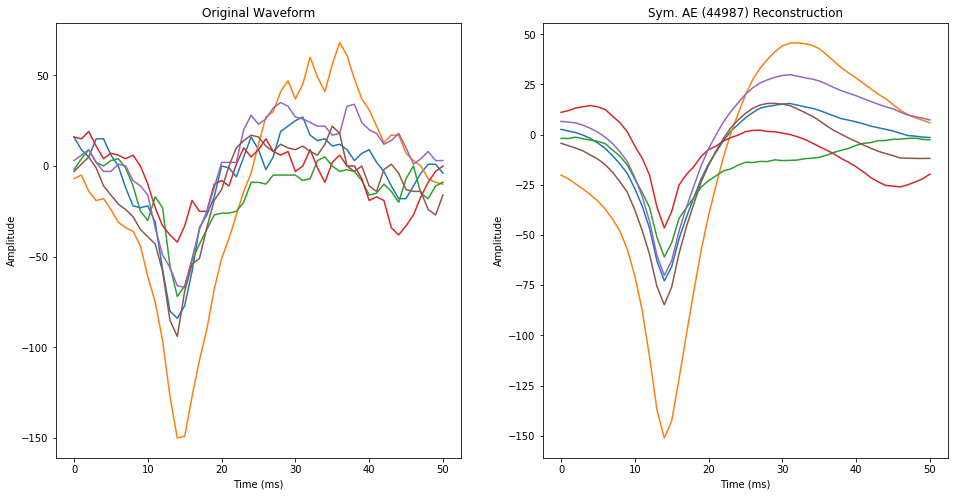

In [178]:
n = sorted([11, 290, 3490, 1098, 2707, 9])

fig1 = plt.figure(figsize=(16, 8))

for i in n:
    plt.subplot(122)
    plt.plot(out_ae[i, :])
    plt.title('Sym. AE (44987) Reconstruction')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.subplot(121)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original Waveform')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
fig1.savefig("recons1.png", bbox_inches='tight')

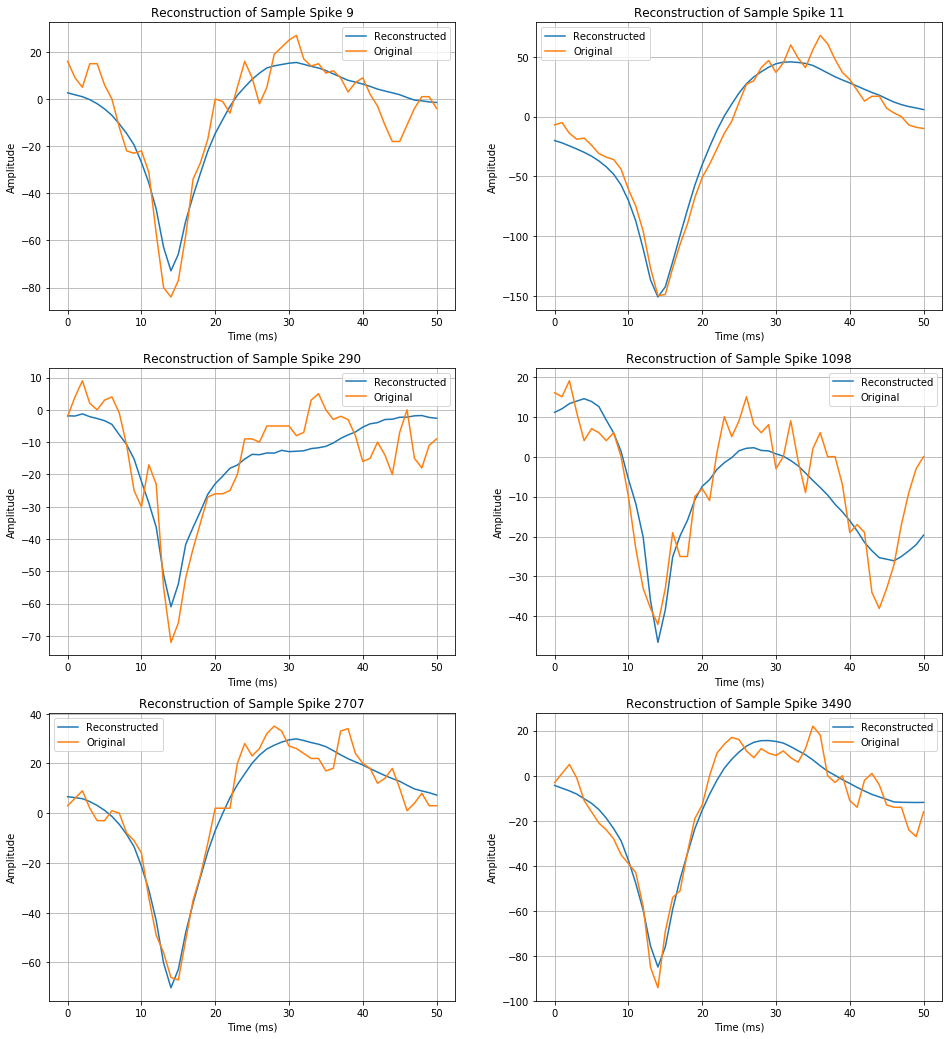

In [175]:
fig2 = plt.figure(figsize=(16, 18))

index = 0
for i in n:
    index += 1
    plt.subplot(320+index)
    plt.title('Reconstruction of Sample Spike '+str(i))
    plt.plot(out_ae[i, :], label="Reconstructed")
    plt.plot(electrode_data_test[i, :], label="Original")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
plt.show()
fig2.savefig("recons2.png", bbox_inches='tight')

# Shallow Model Reconstruction

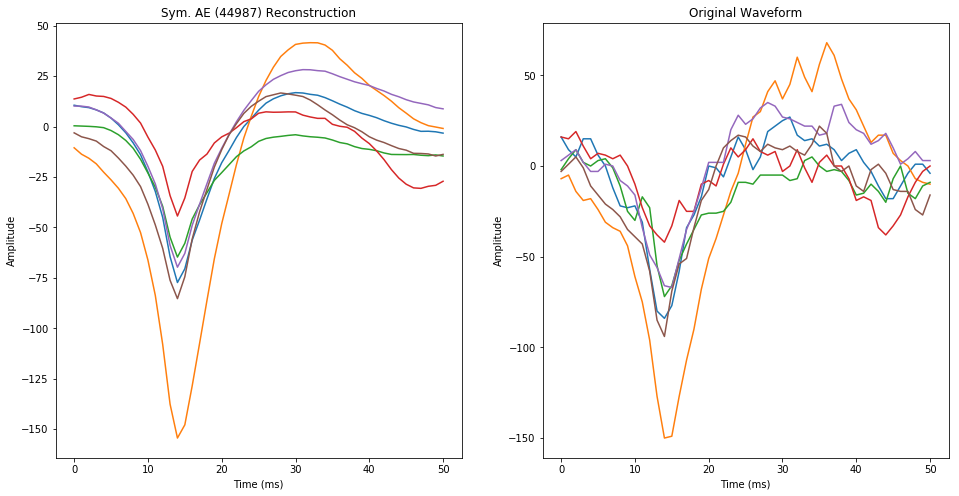

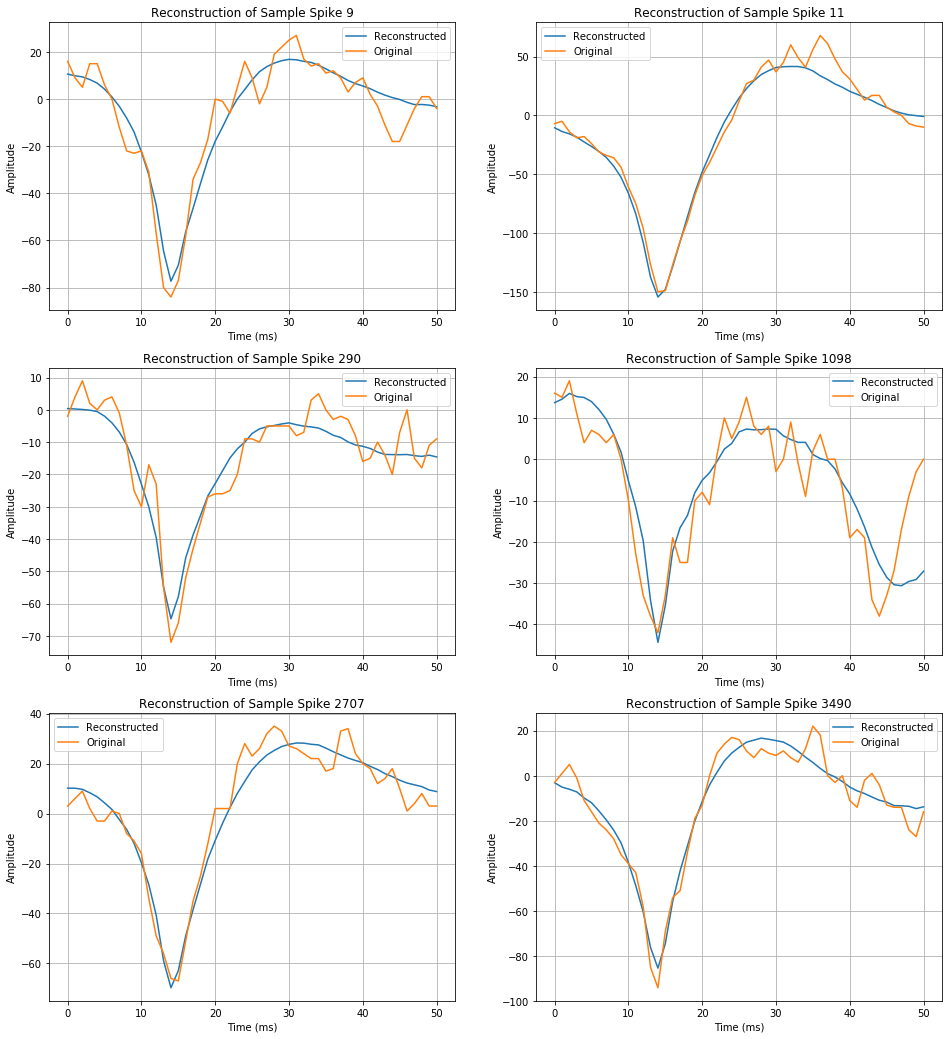

In [176]:
_, out_ae = get_network_output(sym_deepest, 2)

n = sorted([11, 290, 3490, 1098, 2707, 9])

fig1 = plt.figure(figsize=(16, 8))

for i in n:
    plt.subplot(121)
    plt.plot(out_ae[i, :])
    plt.title('Sym. AE (44987) Reconstruction')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.subplot(122)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original Waveform')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

fig2 = plt.figure(figsize=(16, 18))

index = 0
for i in n:
    index += 1
    plt.subplot(320+index)
    plt.title('Reconstruction of Sample Spike '+str(i))
    plt.plot(out_ae[i, :], label="Reconstructed")
    plt.plot(electrode_data_test[i, :], label="Original")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
plt.show()

In [165]:
def plot_loss(vlosses, losses, filename):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(vlosses, label="val")
    plt.plot(losses, label="train")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

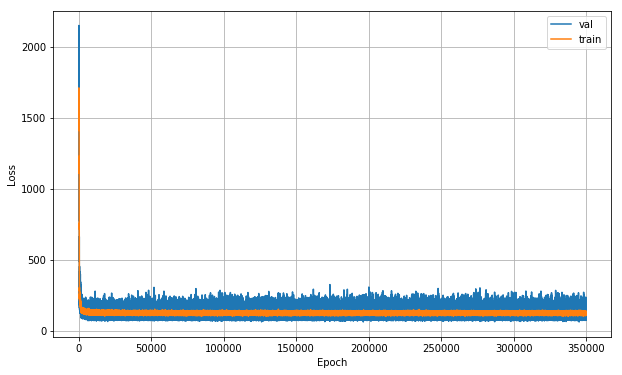

In [166]:
# SHALLOW
v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/final_models/losses_1_2.npy')
plot_loss(v1, t1, "shallow_curve.png")

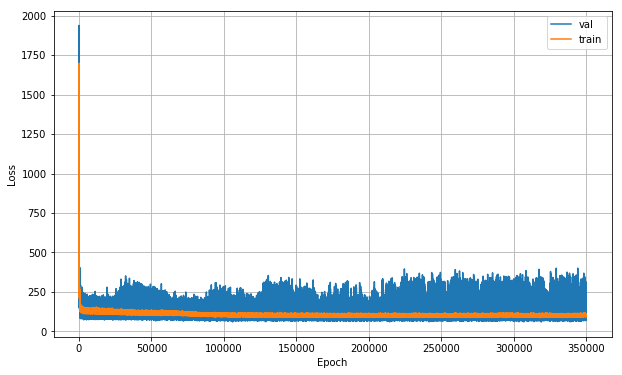

In [167]:
# DEEP
v1 = np.load('models/final_models/vlosses_4_2.npy')
t1 = np.load('models/final_models/losses_4_2.npy')
plot_loss(v1, t1, "deep_curve.png")

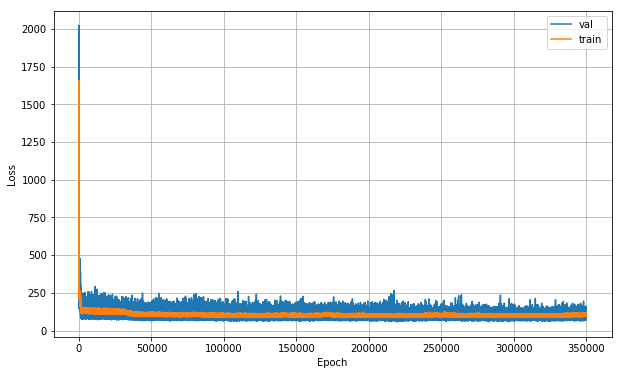

In [168]:
# SUPERDEEP
v1 = np.load('models/final_models/vlosses_6_2.npy')
t1 = np.load('models/final_models/losses_6_2.npy')
plot_loss(v1, t1, "superdeep_curve.png")

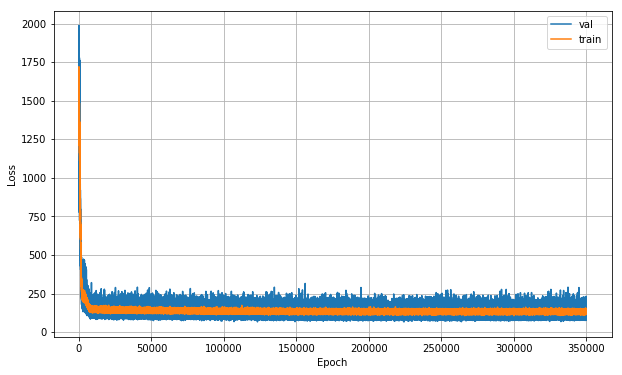

In [169]:
# ASYM SINGLE
v1 = np.load('models/final_models/vlosses_8_2.npy')
t1 = np.load('models/final_models/losses_8_2.npy')
plot_loss(v1, t1, "asym_1_curve.png")

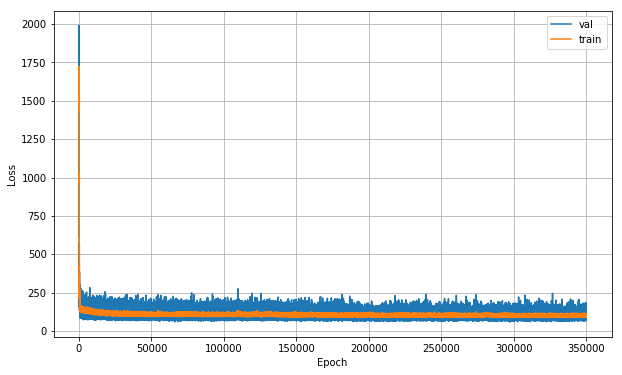

In [170]:
# ASYM MULTI
v1 = np.load('models/final_models/vlosses_5_2.npy')
t1 = np.load('models/final_models/losses_5_2.npy')
plot_loss(v1, t1, "asym_mul_curve.png")

In [75]:
print(np.median(base_corrs))
print(np.median(ae_2_cor))

0.9406087594335943
0.9591819833352391


In [78]:
#0.95818
def relative_improvement(ae_data, pca_data, baseline, ctype):
    ae_improv = ((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = ((np.median(pca_data) - np.median(ae_data))/np.median(pca_data))
    pca_improv *= 100
    
    if ctype == 'cor':
        pca_improv = -pca_improv
        ae_improv = -ae_improv

    print('Baseline improvement: ', round(ae_improv, 5))
    print('PCA improvement: ', round(pca_improv, 5))
    print('\n')

In [ ]:
# out_pca = comp_pca(2)
# pca_mse, pca_med = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
# pca_corrs = np.array(b['PCA'])

# out_base = comp_pca(0)
# base_mse, base_med = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
# base_corrs = np.array(b['Baseline'])

# #sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single = None, None, None, None, None

# ae_1_mse, ae_1_cor, ae_1_mse_med, ae_1_cor_med = find_cor_and_mse(sym_shallow)
# ae_2_mse, ae_2_cor, ae_2_mse_med, ae_2_cor_med = find_cor_and_mse(sym_deep)
# ae_3_mse, ae_3_cor, ae_3_mse_med, ae_3_cor_med = find_cor_and_mse(sym_deepest)
# ae_4_mse, ae_4_cor, ae_4_mse_med, ae_4_cor_med = find_cor_and_mse(asym_single)
# ae_5_mse, ae_5_cor, ae_5_mse_med, ae_5_cor_med = find_cor_and_mse(asym_mult)

In [71]:
# MSE Improvements

relative_improvement(pca_mse, pca_mse, base_mse, ctype='mse')
relative_improvement(ae_1_mse, pca_mse, base_mse, ctype='mse')
relative_improvement(ae_2_mse, pca_mse, base_mse, ctype='mse')
relative_improvement(ae_3_mse, pca_mse, base_mse, ctype='mse')
relative_improvement(ae_4_mse, pca_mse, base_mse, ctype='mse')
relative_improvement(ae_5_mse, pca_mse, base_mse, ctype='mse')

Baseline improvement:  68.36497
PCA improvement:  0.0


Baseline improvement:  68.54626
PCA improvement:  0.57306


Baseline improvement:  72.10131
PCA improvement:  11.81076


Baseline improvement:  72.53749
PCA improvement:  13.18954


Baseline improvement:  68.19218
PCA improvement:  -0.54619


Baseline improvement:  73.38403
PCA improvement:  15.86552




In [79]:
# MSE Improvements

relative_improvement(pca_corrs, pca_corrs, base_corrs, ctype='cor')
relative_improvement(ae_1_cor, pca_corrs, base_corrs, ctype='cor')
relative_improvement(ae_2_cor, pca_corrs, base_corrs, ctype='cor')
relative_improvement(ae_3_cor, pca_corrs, base_corrs, ctype='cor')
relative_improvement(ae_4_cor, pca_corrs, base_corrs, ctype='cor')
relative_improvement(ae_5_cor, pca_corrs, base_corrs, ctype='cor')

Baseline improvement:  0.71279
PCA improvement:  -0.0


Baseline improvement:  0.71416
PCA improvement:  0.00136


Baseline improvement:  1.9746
PCA improvement:  1.25288


Baseline improvement:  1.87808
PCA improvement:  1.15705


Baseline improvement:  0.64321
PCA improvement:  -0.06909


Baseline improvement:  1.88128
PCA improvement:  1.16022


